| MSSV     | Họ và tên       |
|----------|-----------------|
| 19120511 | Võ Văn Hiếu     |
| 19120526 | Huỳnh Đức Huy   |
| 19120539 | Vương Thế Khang |

## Import

In [1]:
# Imporant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import datetime as dt
import warnings

# More libraries
from matplotlib.gridspec import GridSpec

# Scipy
from scipy.stats import boxcox

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Set options
pd.set_option('display.max_colwidth', 200)
sns.set_theme(style = 'whitegrid')

# Config warning
warnings.simplefilter('ignore', category = RuntimeWarning)

# A. THU THẬP DỮ LIỆU

Bộ dữ liệu mà nhóm chọn là bộ dữ liệu từ tập khách hàng đã sử dụng sản phẩm của công ty. Mục tiêu của bài toán đưa ra là phân cụm các khách hàng này thành các phân khúc khách hàng khác nhau, từ đó chọn nhóm khách hàng tiềm năng để tiếp thị sản phẩm mới.

Theo như mô tả về bộ dữ liệu:
> Phân tích tích cách của khách hàng (Customer Personality Analysis) là phân tích chi tiết về khách hàng lý tưởng của công ty. Nó giúp doanh nghiệp hiểu rõ hơn về khách hàng của mình và giúp họ dễ dàng sửa đổi sản phẩm theo nhu cầu, hành vi và mối quan tâm cụ thể của từng loại khách hàng khác nhau.

> Phân tích tính cách khách hàng giúp doanh nghiệp sửa đổi sản phẩm của mình dựa trên khách hàng mục tiêu từ các loại phân khúc khách hàng khác nhau. Ví dụ: thay vì chi tiền để tiếp thị sản phẩm mới cho mọi khách hàng trong cơ sở dữ liệu của công ty, công ty có thể phân tích phân khúc khách hàng nào có nhiều khả năng mua sản phẩm nhất và sau đó chỉ tiếp thị sản phẩm trên phân khúc cụ thể đó.

Các file dữ liệu này bao gồm:
- File "marketing_campaign.csv": bộ dữ liệu được thu thập từ [Kaggle](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)

Người thu thập dữ liệu: Akash Patel [@imakash3011](https://www.kaggle.com/imakash3011)

License: CC0 1.0 Universal (CC0 1.0) Public Domain Dedication

# B. KHÁM PHÁ DỮ LIỆU

Đầu tiên, ta sẽ xem thử bộ dữ liệu trông như thế nào. Đọc dữ liệu từ file "marketing_campaign.csv" và lưu vào dataframe `min_df`.

In [2]:
min_df = pd.read_csv('https://raw.githubusercontent.com/vt-khang/KHDLUD_Tuan11/main/marketing_campaign.csv', sep = '\t')
min_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [3]:
min_df.shape

(2240, 29)

Vậy dữ liệu có kích thước **2240 dòng x 29 cột**.

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin của một khách hàng, có vẻ như không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

Kiểm tra xem dữ liệu có các dòng bị lặp không và lưu kết quả vào biến `have_duplicated_row`. Biến này sẽ có giá trị True nếu dữ liệu có các dòng bị lặp và có giá trị False nếu ngược lại.

In [4]:
have_duplicated_row = any(min_df.duplicated())
have_duplicated_row

False

Như vậy, không có dòng nào bị lặp lại.

### Mỗi cột có ý nghĩa gì?

**Về khách hàng**
- **ID** - ID định danh duy nhất dùng để phân biệt khách hàng
- **Year_Birth** - năm sinh của khách hàng
- **Education** - trình độ học vấn của khách hàng
- **Marital_Status** - tình trạng hôn nhân của khách hàng
- **Income** - thu nhập hộ gia đình hằng năm của khách hàng
- **Kidhome** - số con trong hộ gia đình của khách hàng (từ 0 đến 12 tuổi)
- **Teenhome** - số lượng thanh thiếu niên trong hộ gia đình của khách hàng (từ 13 đến 18 tuổi)
- **Dt_Customer** - ngày đăng ký làm thành viên của khách hàng với công ty
- **Recency** - số ngày kể từ lần mua cuối cùng của khách hàng
- **Complain** - là 1 nếu khách hàng phàn nàn trong 2 năm qua, là 0 nếu không

**Về sản phẩm**: *giả định đơn vị tiền tệ được sử dụng trong dữ liệu là EUR*
- **MntWines** - số tiền chi cho rượu trong 2 năm qua
- **MntFruits** - số tiền chi cho trái cây trong 2 năm qua
- **MntMeatProducts** - số tiền chi cho thịt trong 2 năm qua
- **MntFishProducts** - số tiền chi cho cá trong 2 năm qua
- **MntSweetProducts** - số tiền chi cho đồ ngọt trong 2 năm qua
- **MntGoldProds** - số tiền chi cho vàng trong 2 năm qua

**Về khuyến mãi**
- **NumDealsPurchases** - số lần mua hàng được giảm giá
- **AcceptedCmp1** - là 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch đầu tiên, là 0 nếu không
- **AcceptedCmp2** - là 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 2, là 0 nếu không
- **AcceptedCmp3** - là 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 3, là 0 nếu không
- **AcceptedCmp4** - là 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 4, là 0 nếu không
- **AcceptedCmp5** - là 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch thứ 5, là 0 nếu không
- **Response** - là 1 nếu khách hàng chấp nhận ưu đãi trong chiến dịch cuối cùng, là 0 nếu không

**Về địa điểm**
- **NumWebPurchases** - số lần mua hàng được thực hiện thông qua trang web của công ty
- **NumCatalogPurchases** - số lần mua hàng được thực hiện bằng danh mục được quảng cáo
- **NumStorePurchases** - số lần mua hàng được thực hiện trực tiếp tại các cửa hàng
- **NumWebVisitsMonth** - số lượt truy cập vào trang web của công ty trong tháng trước

**Về các cột khác**
- **Z_CostContact** - chi phí liên hệ của công ty với khách hàng
- **Z_Revenue** - doanh thu nhận được cho mỗi lần liên hệ với khách hàng

### Mỗi cột hiện đang có kiểu dữ liệu gì?

Xem thử kiểu dữ liệu của các cột dữ liệu.

In [5]:
min_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Hiện tại các cột dữ liệu có kiểu dữ liệu đúng, nên ta chỉ chuyển đổi các cột có ít giá trị khác nhau về dạng `category` để tối ưu bộ nhớ và tăng tốc độ xử lý dữ liệu. Vì kiểu dữ liệu `category` sẽ lưu dữ liệu ở dạng mã số thay vì chuỗi ký tự giúp tăng khả năng tối ưu hóa quá trình huấn luyện mô hình.

Như vậy có thể thấy có một số cột đang có kiểu dữ liệu `object` như "Education", "Marital_Status", "Dt_Customer". Ta sẽ sử dụng phương pháp tìm số lượng giá trị phân biệt của từng cột và chọn lọc những cột có ít giá trị phân biệt nhất để đưa các cột này về kiểu dữ liệu dạng phân loại `category`.

Với mỗi cột đang có kiểu dữ liệu là `object`. Ta sẽ tính số lượng các giá trị khác nhau (không xét giá trị NaN) và lưu vào dataframe `object_col_df`. Sau đó sắp xếp theo thứ tự giảm dần số lượng các giá trị khác nhau "nunique".

In [6]:
def nunique(s):
  return s.nunique()

object_cols = min_df.select_dtypes(include = 'object').columns
object_col_df = min_df[object_cols].agg([nunique]).T.sort_values('nunique', ascending = False)
object_col_df

,nunique
Dt_Customer,663
Marital_Status,8
Education,5


Từ bảng thống kê trên, ta thấy các cột "Marital_Status" và "Education" nên đổi thành các cột thuộc dạng phân loại (categorical).

Thay đổi kiểu dữ liệu của các cột "Marital_Status" và "Education" sang kiểu dữ liệu dạng `category`.

In [7]:
min_df[['Marital_Status', 'Education']] = min_df[['Marital_Status', 'Education']].astype('category')

Tương tự như trên, như vậy có thể thấy có một số cột đang có kiểu dữ liệu dạng số number. Ta sẽ sử dụng phương pháp tìm số lượng giá trị phân biệt của từng cột và chọn lọc những cột có ít giá trị phân biệt nhất để đưa các cột này về kiểu dữ liệu dạng phân loại `category`.

Với mỗi cột đang có kiểu dữ liệu dạng số như `int`, `float`. Ta sẽ tính số lượng các giá trị khác nhau (không xét giá trị NaN) và lưu vào dataframe `number_col_df`. Sau đó sắp xếp theo thứ tự giảm dần số lượng các giá trị khác nhau "nunique".

In [8]:
number_cols = min_df.select_dtypes(include = 'number').columns
number_col_df = min_df[number_cols].agg([nunique]).T.sort_values('nunique', ascending = False)
number_col_df

,nunique
ID,2240
Income,1974
MntWines,776
MntMeatProducts,558
MntGoldProds,213
MntFishProducts,182
MntSweetProducts,177
MntFruits,158
Recency,100
Year_Birth,59


Từ bảng thống kê bên trên, ta có thể thấy các cột "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Complain", "Response", "Z_CostContact", "Z_Revenue" đang có kiểu dữ liệu `int`. Ta cần đưa các cột này về dạng `category`.

In [9]:
min_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response', 'Z_CostContact', 'Z_Revenue']] = min_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response', 'Z_CostContact', 'Z_Revenue']].astype('category')

Ngoài ra, ta thấy cột "Dt_Customer" đang có kiểu dữ liệu `object`. Ta cần đưa cột này về dạng `datetime`.

In [10]:
min_df['Dt_Customer'] = pd.to_datetime(min_df['Dt_Customer'], format = '%d-%m-%Y')

Xem lại kiểu dữ liệu của các cột dữ liệu sau khi tiền xử lý.

In [11]:
min_df.dtypes

ID                              int64
Year_Birth                      int64
Education                    category
Marital_Status               category
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                 category
AcceptedCmp4                 category
AcceptedCmp5                 category
AcceptedCmp1                 category
AcceptedCmp2                 category
Complain                     category
Z_CostContac

Có vẻ các cột đều có kiểu dữ liệu phù hợp. Nếu trong quá trình phân tích dữ liệu cần phải thay đổi kiểu dữ liệu của các cột thì ta sẽ quay lại tiền xử lý ở đây, tạm thời ta chấp nhận kiểu dữ liệu hiện tại của các cột.

### Với mỗi cột có kiểu dữ liệu dạng số (numerical), các giá trị được phân bố như thế nào?

Với mỗi cột numerical, ta sẽ tính số lượng giá trị thiếu, tỉ lệ % giá trị thiếu (từ 0 đến 100), số lượng giá trị xuất hiện (count), giá trị nhỏ nhất (min), giá trị trung bình (mean), giá trị trung vị (median), giá trị lớn nhất (max), các khoảng tứ phân vị (Q1, Q2, Q3) và độ lệch chuẩn (std). Sau đó ta sẽ lưu các giá trị này vào dataframe `numerical_col_df` thành 11 dòng là "num_missing_val", "ratio_missing_val", "count", "min", "mean", "median", "max", "Q1", "Q2", "Q3", "std".

In [12]:
def num_missing_val(s):
  return s.isna().sum()
def ratio_missing_val(s):
  return s.isna().mean() * 100
def count(s):
  return s.count();
def Q1(s):
  return s.quantile(0.25)
def Q2(s):
  return s.quantile(0.5)
def Q3(s):
  return s.quantile(0.75)

numerical_cols = min_df.select_dtypes(include = 'number').columns
numerical_col_df = min_df[numerical_cols].agg([num_missing_val, ratio_missing_val, count, min, np.mean, np.median, max, Q1, Q2, Q3, np.std]).T
numerical_col_df[['num_missing_val', 'count']] = numerical_col_df[['num_missing_val', 'count']].astype(int)
numerical_col_df

,num_missing_val,ratio_missing_val,count,min,mean,median,max,Q1,Q2,Q3,std
ID,0,0.000000,2240,0.0,5592.159821,5458.5,11191.0,2828.25,5458.5,8427.75,3246.662198
Year_Birth,0,0.000000,2240,1893.0,1968.805804,1970.0,1996.0,1959.00,1970.0,1977.00,11.984069
Income,24,1.071429,2216,1730.0,52247.251354,51381.5,666666.0,35303.00,51381.5,68522.00,25173.076661
Kidhome,0,0.000000,2240,0.0,0.444196,0.0,2.0,0.00,0.0,1.00,0.538398
Teenhome,0,0.000000,2240,0.0,0.506250,0.0,2.0,0.00,0.0,1.00,0.544538
Recency,0,0.000000,2240,0.0,49.109375,49.0,99.0,24.00,49.0,74.00,28.962453
MntWines,0,0.000000,2240,0.0,303.935714,173.5,1493.0,23.75,173.5,504.25,336.597393
MntFruits,0,0.000000,2240,0.0,26.302232,8.0,199.0,1.00,8.0,33.00,39.773434
MntMeatProducts,0,0.000000,2240,0.0,166.950000,67.0,1725.0,16.00,67.0,232.00,225.715373
MntFishProducts,0,0.000000,2240,0.0,37.525446,12.0,259.0,3.00,12.0,50.00,54.628979


Ta thấy giá trị bị thiếu chỉ xuất hiện ở cột "Income" với tỉ lệ % giá trị bị thiếu khá ít (**~1.07%**). Ta sẽ tiền xử lý giá trị bị thiếu của cột này ở các bước sau.

Ngoài ra, ta biết được khách hàng lâu đời nhất của công ty sinh năm **1893** dựa vào giá trị nhỏ nhất của cột "Year_Birth" và thu nhập của tất cả các hộ gia đình khách hàng luôn **lớn hơn 1730** dựa vào giá trị nhỏ nhất của cột "Income".

### Với mỗi cột có kiểu dữ liệu dạng phân loại (categorical), các giá trị được phân bố như thế nào?

Với mỗi cột categorical, ta sẽ tính số lượng giá trị thiếu, tỉ lệ % giá trị thiếu (từ 0 đến 100), số lượng giá trị xuất hiện (count), giá trị xuất hiện nhiều nhất (mode), số lượng giá trị xuất hiện nhiều nhất (không xét giá trị NaN), số lượng các giá trị khác nhau (không xét giá trị NaN) và danh sách các giá trị khác nhau (không xét giá trị NaN). Sau đó ta sẽ lưu các giá trị này vào dataframe `categical_col_df` thành 7 dòng là "num_missing_val", "ratio_missing_val", "count", "top", "freq", "nunique", "unique".

In [13]:
def unique(s):
  return s.dropna().astype('object').unique()
def top(s):
  return s.mode()[0]
def freq(s):
  return (s == s.mode()[0]).value_counts()[True]

categorical_cols = min_df.select_dtypes(exclude = 'number').columns
categorical_col_df = min_df[categorical_cols].agg([num_missing_val, ratio_missing_val, count, top, freq, nunique, unique]).T
categorical_col_df[['num_missing_val', 'count']] = categorical_col_df[['num_missing_val', 'count']].astype(int)
categorical_col_df

,num_missing_val,ratio_missing_val,count,top,freq,nunique,unique
Education,0,0.0,2240,Graduation,1127,5,"[Graduation, PhD, Master, Basic, 2n Cycle]"
Marital_Status,0,0.0,2240,Married,864,8,"[Single, Together, Married, Divorced, Widow, Alone, Absurd, YOLO]"
Dt_Customer,0,0.0,2240,2012-08-31 00:00:00,12,663,"[2012-09-04 00:00:00, 2014-03-08 00:00:00, 2013-08-21 00:00:00, 2014-02-10 00:00:00, 2014-01-19 00:00:00, 2013-09-09 00:00:00, 2012-11-13 00:00:00, 2013-05-08 00:00:00, 2013-06-06 00:00:00, 2014-0..."
AcceptedCmp3,0,0.0,2240,0,2077,2,"[0, 1]"
AcceptedCmp4,0,0.0,2240,0,2073,2,"[0, 1]"
AcceptedCmp5,0,0.0,2240,0,2077,2,"[0, 1]"
AcceptedCmp1,0,0.0,2240,0,2096,2,"[0, 1]"
AcceptedCmp2,0,0.0,2240,0,2210,2,"[0, 1]"
Complain,0,0.0,2240,0,2219,2,"[0, 1]"
Z_CostContact,0,0.0,2240,3,2240,1,[3]


Ta thấy tất cả các cột dạng phân loại đều không có xuất hiện giá trị bị thiếu. 

Tuy nhiên có 2 cột "Z_CostContact" và "Z_Revenue" chỉ có xuất hiện duy nhất 1 giá trị phân biệt, hay nói cách khác có cùng 1 giá trị ở mọi hàng trong tập dữ liệu và cột này sẽ không có ý nghĩa gì cho việc xây dựng mô hình học máy sau này. Do đó loại bỏ 2 cột "Z_CostContact" và "Z_Revenue" ra khỏi bộ dữ liệu.

In [14]:
min_df = min_df.drop(columns = ['Z_CostContact', 'Z_Revenue'], axis = 1)

In [15]:
print(min_df.shape)

(2240, 27)


Sau khi loại bỏ 2 cột trên, tập dữ liệu có kích thước **2240 dòng x 27 cột**.

Đối với cột "Education", ta có thể phân loại thành 2 kiểu trình độ học vấn sau:
- **PG** (Postgraduate) - dành cho các bậc đào tào sau đại học như: Graduation, PhD, Master, 2n Cycle
- **UG** (Undergraduate) - dành cho đại học nói chung như Basic

In [16]:
min_df['Education'] = min_df['Education'].replace(['PhD', '2n Cycle', 'Graduation', 'Master'], 'PG')  
min_df['Education'] = min_df['Education'].replace(['Basic'], 'UG')

Đối với cột "Marital_Status", ta có thể phân loại thành 2 kiểu tình trạng hôn nhân sau:
- **Relationship** - dành cho các mối quan hệ đã kết hôn hoặc sống chung với nhau như: Married, Together
- **Single** - dành cho tình trạng độc thân như: Divorced, Widow, Alone, YOLO, Absurd

In [17]:
min_df['Marital_Status'] = min_df['Marital_Status'].replace(['Married', 'Together'], 'Relationship')
min_df['Marital_Status'] = min_df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'], 'Single')

Cuối cùng, ta sẽ xem lại bảng thống kê mô tả của các cột dạng phân loại.

In [18]:
categorical_col_df = min_df[['Education', 'Marital_Status']].agg([num_missing_val, ratio_missing_val, count, top, freq, nunique, unique]).T
categorical_col_df[['num_missing_val', 'count']] = categorical_col_df[['num_missing_val', 'count']].astype(int)
categorical_col_df

,num_missing_val,ratio_missing_val,count,top,freq,nunique,unique
Education,0,0.0,2240,PG,2186,2,"[PG, UG]"
Marital_Status,0,0.0,2240,Relationship,1444,2,"[Single, Relationship]"


Các cột dạng phân loại còn lại có vẻ không có gì bất thường.

# C. TRỰC QUAN HÓA DỮ LIỆU

### Biểu đồ thể hiện tỉ lệ khách hàng theo từng loại trình độ học vấn và theo tình trạng hôn nhân

Ta sẽ dùng 2 loại biểu đồ tròn để thể hiện điều này.
- Xét biểu đồ thể hiện tỉ lệ khách hàng theo từng loại trình độ học vấn (Education). Trong đó:
  - Màu xanh: thể hiện khách hàng có trình độ học vấn sau đại học (PG)
  - Màu cam: thể hiện khách hàng có trình độ học vấn đại học (UG)
- Xét biểu đồ thể hiện tỉ lệ khách hàng theo từng loại tình trạng hôn nhân (Marital_Status). Trong đó:
  - Màu xanh: thể hiện khách hàng có tình trạng hôn nhân là đang trong mối quan hệ (Relationship)
  - Màu cam: thể hiện khách hàng có tình trạng hôn nhân là độc thân (Single)

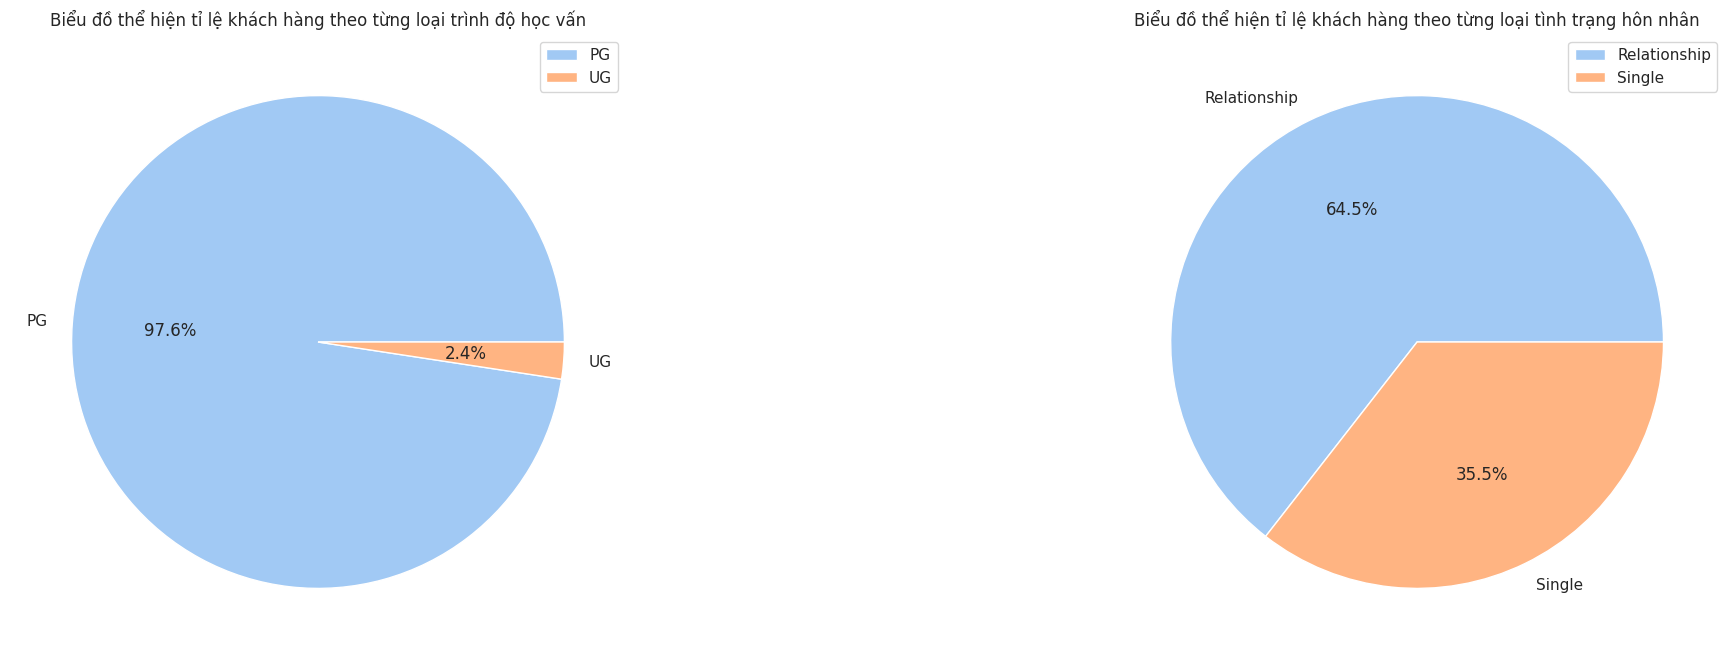

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (26, 8))
ax[0].pie(min_df['Education'].value_counts(), labels = min_df['Education'].value_counts().index, colors = sns.color_palette('pastel'), autopct = '%1.1f%%')
ax[0].set_title('Biểu đồ thể hiện tỉ lệ khách hàng theo từng loại trình độ học vấn')
ax[0].legend()
ax[1].pie(min_df['Marital_Status'].value_counts(), labels = min_df['Marital_Status'].value_counts().index, colors = sns.color_palette('pastel'), autopct = '%1.1f%%')
ax[1].set_title('Biểu đồ thể hiện tỉ lệ khách hàng theo từng loại tình trạng hôn nhân')
ax[1].legend()
plt.show()

**Nhận xét:** Quan sát 2 biểu đồ trên, ta nhận thấy:
- Có hơn **97.6%** khách hàng có hồ sơ là sau đại học (PG) và có khoảng **2.4%** khách hàng có hồ sơ là đại học (UG). Như vậy đa số tập khách hàng của công ty đều có trình độ học vấn sau đại học.
- Có khoảng **35.5%** khách hàng là độc thân (Single) trong khi có hơn **64.5%** khách hàng đang trong mối quan hệ (Relationship). Điều này cho thấy khách hàng của công ty chủ yếu là đã kết hôn hoặc đang sinh sống cùng nhau.

### Biểu diễn thể hiện sự phân phối về độ tuổi của khách hàng

Ta sẽ dùng biểu đồ cột để thể hiện số lượng khách hàng theo từng độ tuổi. Trong đó:
- Trục hoành: thể hiện các năm sinh (Year_Birth).
- Trục tung: thể hiện số người theo từng năm sinh.

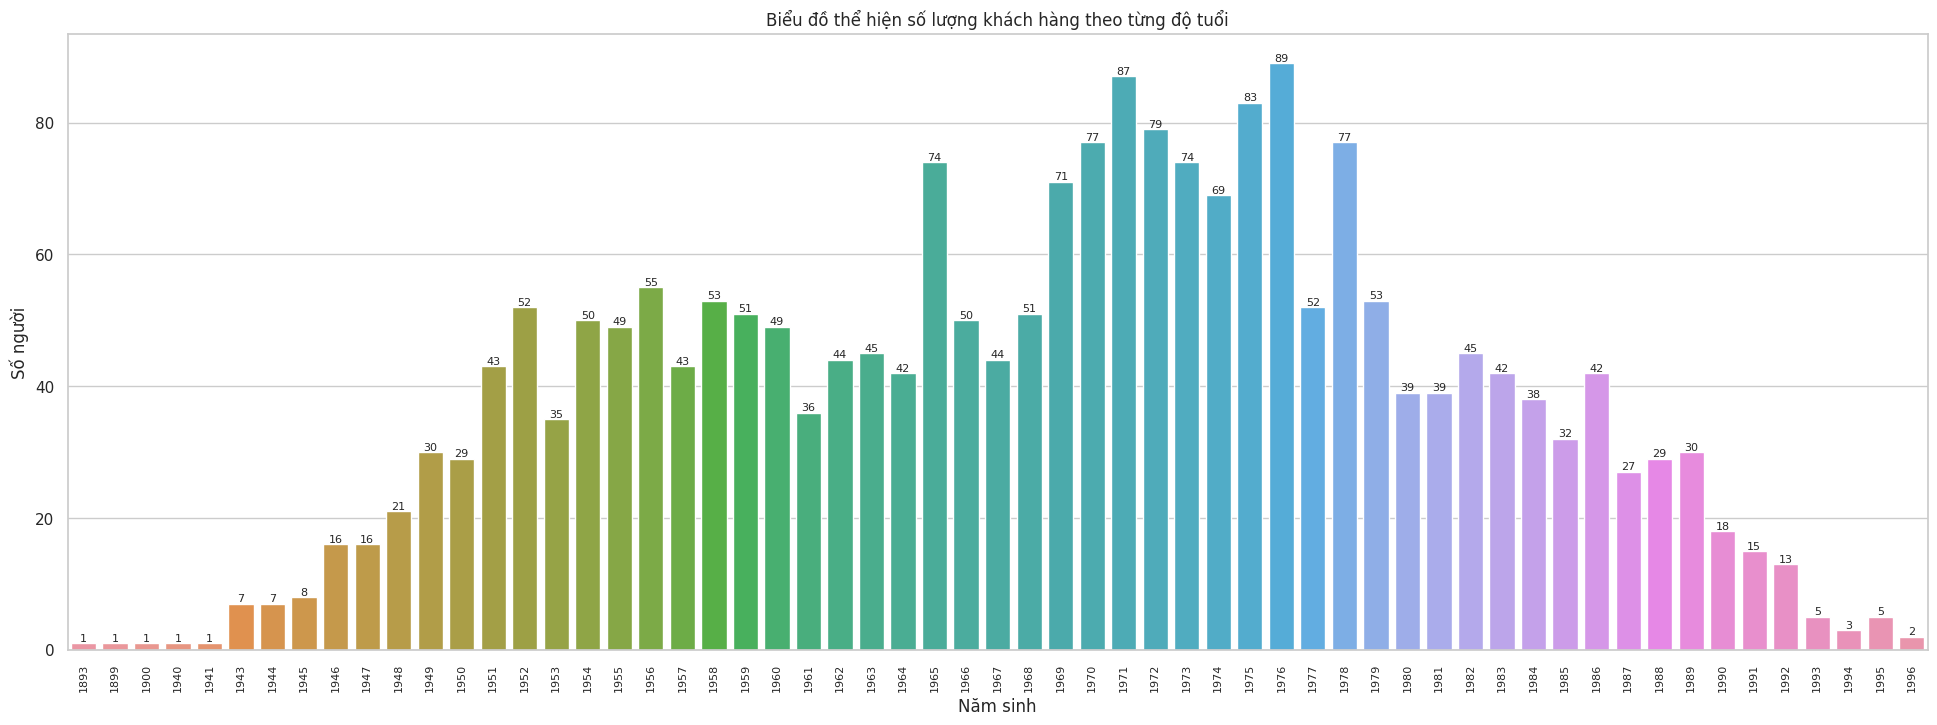

In [20]:
fig, ax = plt.subplots(figsize = (24, 8))
sns.countplot(data = min_df, x = 'Year_Birth', ax = ax)
ax.bar_label(ax.containers[0], fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)
plt.title('Biểu đồ thể hiện số lượng khách hàng theo từng độ tuổi')
plt.xlabel('Năm sinh')
plt.ylabel('Số người')
plt.show()

**Nhận xét:** Quan sát biểu đồ trên, ta nhận thấy:
- Khách hàng trẻ tuổi nhất của công ty sinh năm **1996** còn khách hàng lớn tuổi nhất của công ty sinh năm **1893**.
- Công ty có tập khách hàng nhiều nhất chủ yếu tập trung từ năm sinh **1969** đến năm sinh **1978**, điều này cũng dễ hiểu vì những người trong độ tuổi có thể lao động kiếm sống và có đủ điều kiện để quan tâm đến việc mua sắm thường xuyên.

### Biểu đồ thể hiện phân phối thu nhập của khách hàng theo từng loại trình độ học vấn và tình trạng hôn nhân

Ta sẽ dùng 2 loại biểu đồ histogram để thể hiện điều này. Lưu ý ở đây ta chỉ xét thu nhập dưới 100000.
- Xét biểu đồ thể hiện phân phối thu nhập (Income) của khách hàng theo từng loại trình độ học vấn (Education). Trong đó:
  - Màu xanh: thể hiện khách hàng có trình độ học vấn đại học (UG)
  - Màu cam: thể hiện khách hàng có trình độ học vấn sau đại học (PG)
- Xét biểu đồ thể hiện phân phối thu nhập (Income) của khách hàng theo từng loại tình trạng hôn nhân (Marital_Status). Trong đó:
  - Màu xanh: thể hiện khách hàng có tình trạng hôn nhân là đang trong mối quan hệ (Relationship)
  - Màu cam: thể hiện khách hàng có tình trạng hôn nhân là độc thân (Single)

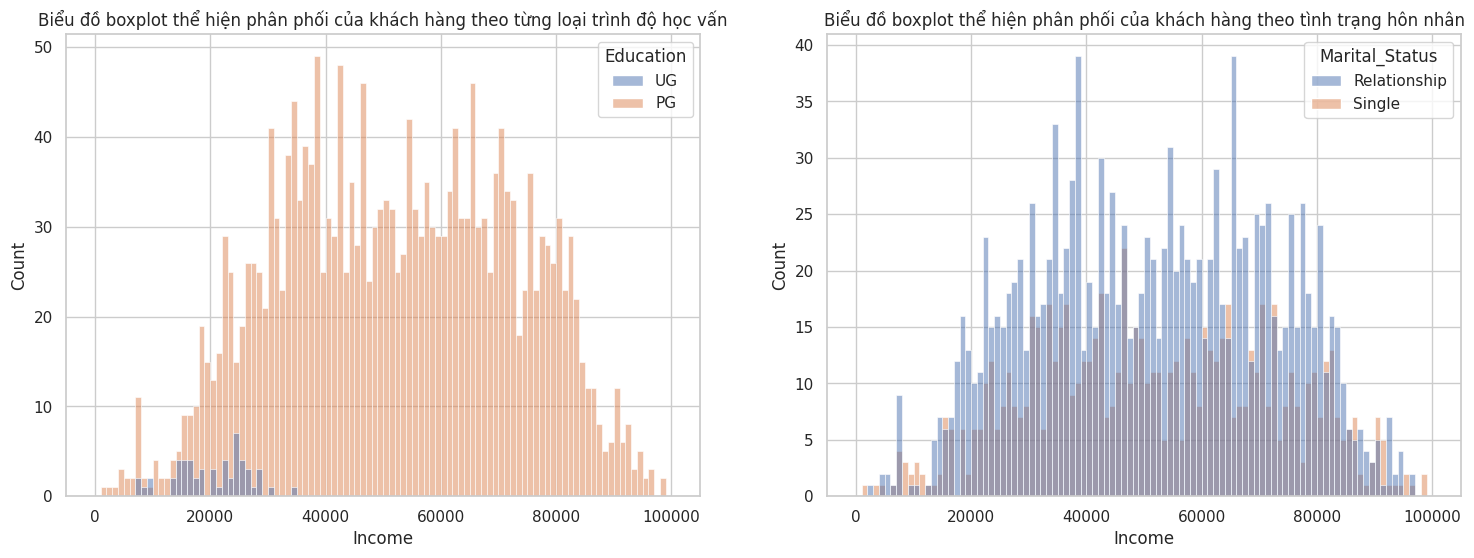

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
sns.histplot(data = min_df, x = 'Income', hue = 'Education', bins = 100, binrange = (0, 100000), ax = ax[0])
ax[0].set_title('Biểu đồ boxplot thể hiện phân phối của khách hàng theo từng loại trình độ học vấn')
sns.histplot(data = min_df, x = 'Income', hue = 'Marital_Status', bins = 100, binrange = (0, 100000), ax = ax[1])
ax[1].set_title('Biểu đồ boxplot thể hiện phân phối của khách hàng theo tình trạng hôn nhân')
plt.show()

**Nhận xét:** Quan sát 2 biểu đồ trên, ta nhận thấy:
- Đối với phân phối thu nhập của khách hàng theo trình độ học vấn, những khách hàng thuộc trình độ học vấn đại học (UG) sẽ có thu nhập không quá 40000. Trong khi tập khách hàng thuộc nhóm khách hàng có trình độ học vấn sau đại học (PG) lại nhiều hơn 10000. Điều này cũng dễ hiểu vì những người đang học đại học, thường là sinh viên sẽ không có nhiều nguồn thu nhập và chi phí để mua sắm thường xuyên, điều đó tỉ lệ thuận với sự tiết kiệm của loại khách hàng đó.
- Đối với phân phối thu nhập của khách hàng theo tình trạng hôn nhân, đa phần khách hàng của 2 nhóm đều có thu nhập nhiều hơn 10000. Tuy nhiên do tỉ lệ nhóm khách hàng có tình trạng độc thân ít hơn nhóm khách hàng có tình trạng kết hôn nên số lượng người theo mức thu nhập tương ứng cũng ít hơn.

### Biểu đồ thể hiện phân bố của các loại chiến dịch được sử dụng cho từng loại khách hàng

Ta sẽ dùng biểu đồ cột để thể hiện số lượng người tham gia theo từng loại chiến dịch của công ty. Trong đó:
- Trục hoành: thể hiện tên các loại chiến dịch (Campaign).
- Trục tung: thể hiện số người tham gia theo từng loại chiến dịch.

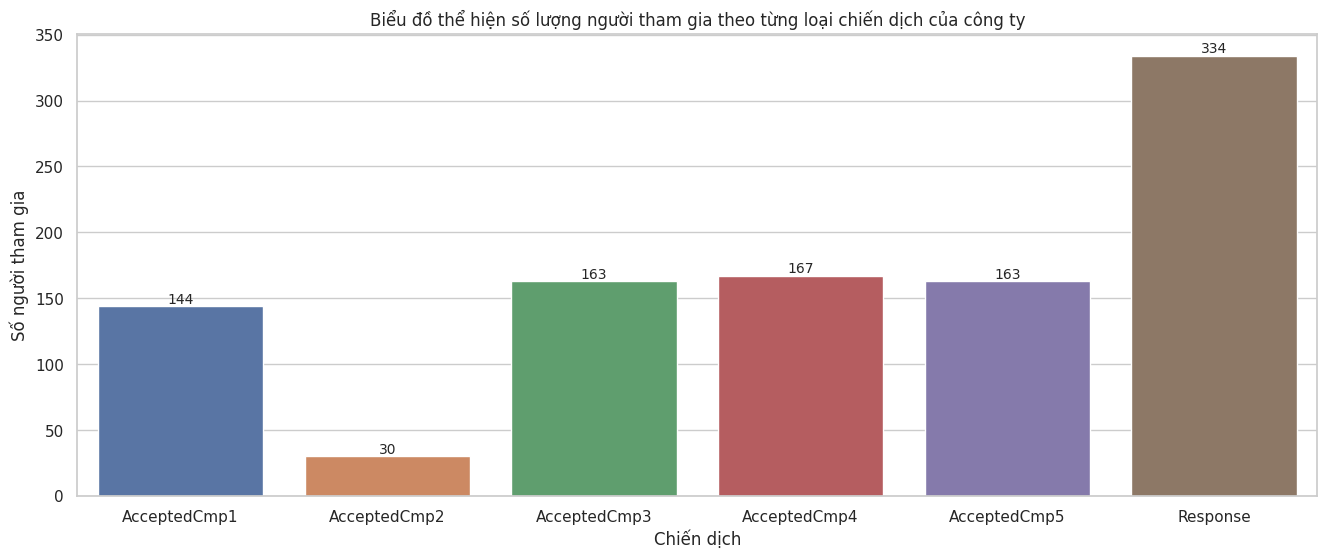

In [22]:
camp_df = pd.DataFrame({ 'Campaign': ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'],
                         'Count': [min_df[min_df['AcceptedCmp1'] == 1].shape[0],
                                   min_df[min_df['AcceptedCmp2'] == 1].shape[0],
                                   min_df[min_df['AcceptedCmp3'] == 1].shape[0],
                                   min_df[min_df['AcceptedCmp4'] == 1].shape[0],
                                   min_df[min_df['AcceptedCmp5'] == 1].shape[0],
                                   min_df[min_df['Response'] == 1].shape[0]] })
fig, ax = plt.subplots(figsize = (16, 6))
sns.barplot(data = camp_df, x = 'Campaign', y = 'Count', ax = ax)
ax.bar_label(ax.containers[0], fontsize = 10)
plt.title('Biểu đồ thể hiện số lượng người tham gia theo từng loại chiến dịch của công ty')
plt.xlabel('Chiến dịch')
plt.ylabel('Số người tham gia')
plt.show()

**Nhận xét:** Quan sát biểu đồ trên, ta có thể thấy:
- Hầu hết khách hàng đều tham gia chiến dịch cuối cùng (Response) với **334** người, trong khi đó có rất ít khách hàng tham gia chiến dịch thứ 2 (AcceptedCmp2) khi chỉ có **30** người.
- Đối với các chiến dịch còn lại có số lượng người tham gia khá đều nhau, có thể thời gian từ lúc mở chiến dịch cho tới khi chiến dịch đó được đóng đều ngang nhau.

# D. TIỀN XỬ LÝ DỮ LIỆU

### Xử lý các giá trị bị thiếu (Missing Values)

Trước tiên, ta sẽ tạo lại bảng thống kê mô tả về giá trị bị thiếu của các đặc trưng ở trên. Với mỗi cột, ta sẽ tính số lượng giá trị thiếu, tỉ lệ % giá trị thiếu (từ 0 đến 100). Sau đó ta sẽ lưu các giá trị này vào dataframe `col_df` thành 2 dòng là "num_missing_val", "ratio_missing_val".

In [23]:
col_df = min_df.agg([num_missing_val, ratio_missing_val]).T
col_df['num_missing_val'] = col_df['num_missing_val'].astype(int)
col_df

,num_missing_val,ratio_missing_val
ID,0,0.000000
Year_Birth,0,0.000000
Education,0,0.000000
Marital_Status,0,0.000000
Income,24,1.071429
Kidhome,0,0.000000
Teenhome,0,0.000000
Dt_Customer,0,0.000000
Recency,0,0.000000
MntWines,0,0.000000


Dựa vào bảng thống kê mô tả của các đặc trưng ở trên, ta thấy chỉ xuất hiện các giá trị bị thiếu ở cột "Income".

Ta thấy cột "Income" có tỉ lệ % giá trị bị thiếu khá ít **(1.07%)** nên ta sẽ chọn cách thay các giá trị bị thiếu ở cột này thành giá trị trung bình (mean).

In [24]:
min_df['Income'] = min_df['Income'].fillna(min_df['Income'].mean())

Sau đó, ta sẽ kiểm tra lại các giá trị bị thiếu có còn xuất hiện sau khi thực hiện tiền xử lý dữ liệu bị thiếu.

In [25]:
min_df.isnull().sum().sort_values(ascending = False)

ID                     0
MntGoldProds           0
Complain               0
AcceptedCmp2           0
AcceptedCmp1           0
AcceptedCmp5           0
AcceptedCmp4           0
AcceptedCmp3           0
NumWebVisitsMonth      0
NumStorePurchases      0
NumCatalogPurchases    0
NumWebPurchases        0
NumDealsPurchases      0
MntSweetProducts       0
Year_Birth             0
MntFishProducts        0
MntMeatProducts        0
MntFruits              0
MntWines               0
Recency                0
Dt_Customer            0
Teenhome               0
Kidhome                0
Income                 0
Marital_Status         0
Education              0
Response               0
dtype: int64

Có vẻ các cột đều không còn xuất hiện giá trị bị thiếu.

Cuối cùng, cột "ID" có chứa thông tin phân biệt và không thể dùng cho các mô hình học máy sau này. Do đó, ta sẽ bỏ đi cột "ID".

In [26]:
min_df = min_df.drop(columns = ['ID'], axis = 1)

In [27]:
min_df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,PG,Single,58138.0,0,0,2012-09-04,58,635,88,...,10,4,7,0,0,0,0,0,0,1
1,1954,PG,Single,46344.0,1,1,2014-03-08,38,11,1,...,1,2,5,0,0,0,0,0,0,0
2,1965,PG,Relationship,71613.0,0,0,2013-08-21,26,426,49,...,2,10,4,0,0,0,0,0,0,0
3,1984,PG,Relationship,26646.0,1,0,2014-02-10,26,11,4,...,0,4,6,0,0,0,0,0,0,0
4,1981,PG,Relationship,58293.0,1,0,2014-01-19,94,173,43,...,3,6,5,0,0,0,0,0,0,0


In [28]:
print(min_df.shape)

(2240, 26)


Sau khi tiền xử lý các giá trị bị thiếu, số chiều của dữ liệu đã giảm còn **26 cột**.

### Khám phá đặc trưng (Feature Engineering)

Đầu tiên, ta sẽ tạo ra thêm các cột sau bằng cách kết hợp từ các cột có sẵn:
- **Kids**: được kết hợp từ cột "Kidhome" và "Teenhome" thể hiện số lượng người trong hộ gia đình của khách hàng.
- **Expenses**: được kết hợp từ các cột "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds" thể hiện số tiền chi tiêu cho tất cả các sản phẩm trong 2 năm qua.
- **TotalAcceptedCmp**: được kết hợp từ các cột "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response" thể hiện tổng số lượng chiến dịch mà khách hàng tham gia.
- **NumTotalPurchases**: được kết hợp từ các cột "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases" thể hiện tổng số lần mua hàng của khách hàng trên mọi nền tảng.

In [29]:
min_df['Kids'] = min_df['Kidhome'].astype(int) + min_df['Teenhome'].astype(int)
min_df['Expenses'] = min_df['MntWines'] + min_df['MntFruits'] + min_df['MntMeatProducts'] + min_df['MntFishProducts'] + min_df['MntSweetProducts'] + min_df['MntGoldProds']
min_df['TotalAcceptedCmp'] = min_df['AcceptedCmp1'].astype(int) + min_df['AcceptedCmp2'].astype(int) + min_df['AcceptedCmp3'].astype(int) + min_df['AcceptedCmp4'].astype(int) + min_df['AcceptedCmp5'].astype(int) + min_df['Response'].astype(int)
min_df['NumTotalPurchases'] = min_df['NumDealsPurchases'] + min_df['NumWebPurchases'] + min_df['NumCatalogPurchases'] + min_df['NumStorePurchases']

Tương ứng với việc tạo ra thêm các cột mới như trên, ta sẽ lần lượt xóa đi các cột được kết hợp.

In [30]:
del_cols = ['Kidhome', 'Teenhome', 
            'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
            'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
            'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
min_df = min_df.drop(columns = del_cols, axis = 1)

Tiếp theo, ta sẽ tạo ra cột "Age" để tính tuổi của khách hàng dựa vào cột "Year_Birth".

In [31]:
current_year = dt.datetime.now().year
min_df['Age'] = current_year - min_df['Year_Birth']
min_df = min_df.drop(columns = ['Year_Birth'], axis = 1)

Cuối cùng, ta sẽ tạo ra cột "Day_Engaged" để tính số ngày mà khách hàng gắn bó với công ty dựa vào cột "Dt_Customer". Sau đó ta sẽ xóa đi cột "Recency" và "Complain" vì có cùng ý nghĩa với cột "Day_Engaged".

In [32]:
current_date = dt.datetime.now()
min_df['Day_Engaged'] = (current_date - min_df['Dt_Customer']).dt.days
min_df = min_df.drop(columns = ['Dt_Customer', 'Recency', 'Complain'], axis = 1)

In [33]:
min_df.head()

,Education,Marital_Status,Income,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Day_Engaged
0,PG,Single,58138.0,0,1617,1,25,66,3904
1,PG,Single,46344.0,2,27,0,6,69,3354
2,PG,Relationship,71613.0,0,776,0,21,58,3553
3,PG,Relationship,26646.0,1,53,0,8,39,3380
4,PG,Relationship,58293.0,1,422,0,19,42,3402


In [34]:
print(min_df.shape)

(2240, 9)


Sau khi tiền xử lý khám phá đặc trưng, số chiều của dữ liệu đã giảm còn **12 cột**.

### Mã hóa đặc trưng (Feature Encoding)

Để hoàn thiện quá trình biến dữ liệu dạng phân loại về dạng số phù hợp cho các mô hình học máy, ta cần mã hóa các cột này theo các phương pháp sau. Đối với các cột dạng phân loại không có thứ tự như "Education" và "Marital_Status" ta sẽ dùng phương pháp mã hóa Label Encoding.

Đối với cột "Education", ta sẽ quy định mã hóa như sau:
- UG: ta chuyển thành số 0
- PG: ta chuyển thành số 1

Còn đối với cột "Marital_Status", ta sẽ quy định mã hóa như sau:
- Single: ta chuyển thành số 0
- Relationship: ta chuyển thành số 1

In [35]:
min_df['Education'] = min_df['Education'].replace({ 'UG': 0, 'PG': 1 })
min_df['Marital_Status'] = min_df['Marital_Status'].replace({ 'Single': 0, 'Relationship': 1 })

Sau đó, ta sẽ chuyển lại kiểu dữ liệu của các cột dạng phân loại `category` về dạng `int`.

In [36]:
min_df[min_df.select_dtypes(include = 'category').columns] = min_df[min_df.select_dtypes(include = 'category').columns].astype(int)

Cuối cùng, ta sẽ xem thử kiểu dữ liệu của các cột dữ liệu sau khi tiền xử lý mã hóa đặc trưng.

In [37]:
min_df.dtypes

Education              int64
Marital_Status         int64
Income               float64
Kids                   int64
Expenses               int64
TotalAcceptedCmp       int64
NumTotalPurchases      int64
Age                    int64
Day_Engaged            int64
dtype: object

Như vậy, tất cả các cột dữ liệu đã được đưa về dạng số.

### Chuyển đổi dữ liệu (Data Trasformation)

Ta sẽ dùng biểu đồ histogram đối với các cột dạng số (cột "Income") để biết được sự phân phối của dữ liệu. Đồng thời trong biểu đồ histogram ta cũng cần tính độ lệch (Skewness) tương ứng. Trong đó:
- Nếu độ lệch của đặc trưng đó có giá trị âm chứng tỏ phân phối dữ liệu của đặc trưng đó bị lệch trái.
- Nếu độ lệch của đặc trưng đó có giá trị dương chứng tỏ phân phối dữ liệu của đặc trưng đó bị lệch phải.

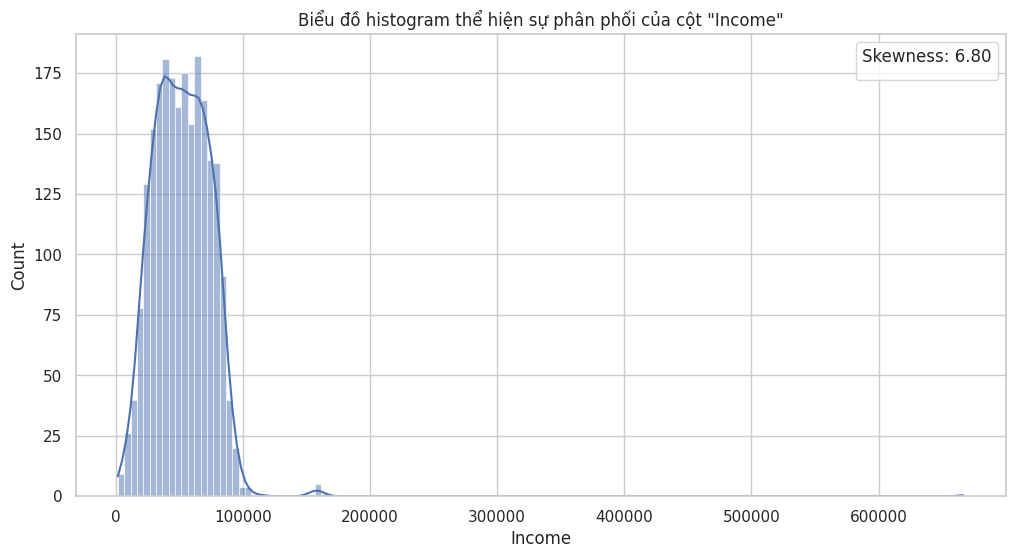

In [38]:
plt.figure(figsize = (12, 6))
sns.histplot(min_df['Income'], kde = True, legend = True)
plt.legend([], title = 'Skewness: %.2f'%(min_df['Income'].skew()))
plt.title('Biểu đồ histogram thể hiện sự phân phối của cột "Income"')
plt.show()

Từ các biểu đồ trên, ta sẽ loại bỏ độ lệch hiện có của cột "Income" (có độ lệch **6.8**) và đưa dữ liệu gần giống với phân phối chuẩn bằng phương pháp Box Cox Transformation.

Sau đó, ta cũng dùng các biểu đồ histogram đối với các cột dữ liệu thuộc `skewed_features` để biết được sự phân phối của dữ liệu sau khi đã chuyển đổi.

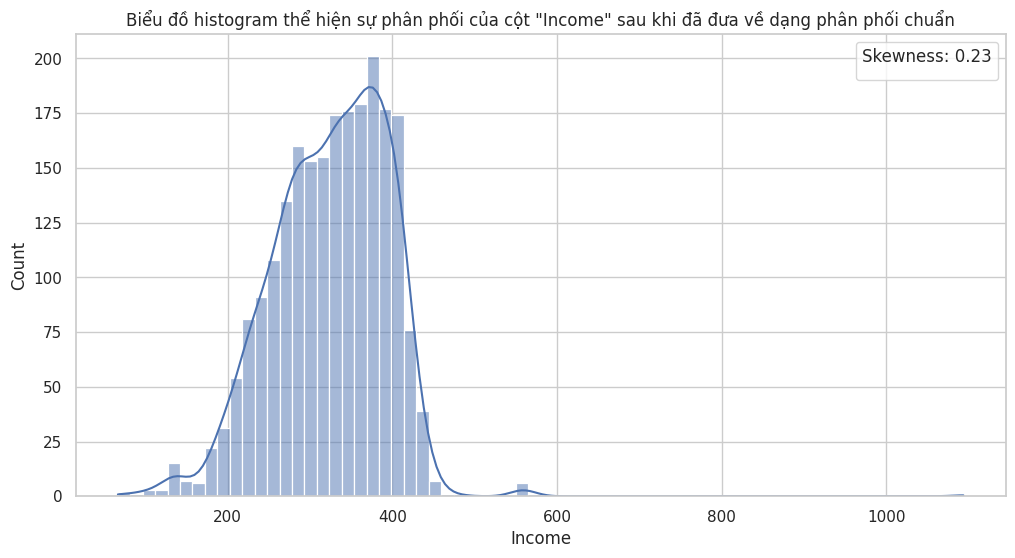

In [39]:
plt.figure(figsize = (12, 6))
min_df['Income'], _ = boxcox(min_df['Income'])
sns.histplot(min_df['Income'], kde = True, legend = True)
plt.legend([], title = 'Skewness: %.2f'%(min_df['Income'].skew()))
plt.title('Biểu đồ histogram thể hiện sự phân phối của cột "Income" sau khi đã đưa về dạng phân phối chuẩn')
plt.show()

Quan sát các biểu đồ trên, ta thấy độ lệch sau khi tiền xử lý nằm trong khoảng **từ -1 đến 1** và biểu đồ có dạng hình chuông chứng tỏ dữ liệu đã được đưa về dạng phân phối chuẩn.

Cuối cùng, ta sẽ sử dụng phương pháp chuẩn hóa Min Max Scaler các giá trị có trong các cột dạng số để dễ dàng đưa vào các mô hình học máy sau này.

In [40]:
scaler = StandardScaler()
min_df[min_df.columns] = scaler.fit_transform(min_df)

In [41]:
min_df.head()

,Education,Marital_Status,Income,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Day_Engaged
0,0.157171,-1.346874,0.365968,-1.264505,1.679417,0.621248,1.320826,0.985345,1.531185
1,0.157171,-1.346874,-0.140537,1.396361,-0.961275,-0.501912,-1.154596,1.235733,-1.190545
2,0.157171,0.742460,0.881184,-1.264505,0.282673,-0.501912,0.799685,0.317643,-0.205773
3,0.157171,0.742460,-1.174271,0.065928,-0.918094,-0.501912,-0.894025,-1.268149,-1.061881
4,0.157171,0.742460,0.372239,0.065928,-0.305254,-0.501912,0.539114,-1.017761,-0.953012


Các cột dạng số đều đã thu hẹp khoảng giá trị về gần giá trị 0.

### Trích xuất đặc trưng (Feature Selection)

Đầu tiên, ta sẽ vẽ biểu đồ heatmap để thể hiện sự phụ thuộc và tương quan giữa các trường trong dữ liệu. Trong đó:
- Mỗi màu sắc càng nhạt sẽ thể hiện độ tương quan nghịch càng mạnh (càng gần giá trị -1).
- Mỗi màu sắc càng đậm sẽ thể hiện độ tương quan thuận càng mạnh (càng gần giá trị 1).
- Mỗi màu sắc trung gian sẽ thể hiện độ tương quan yếu (càng gần giá trị 0).

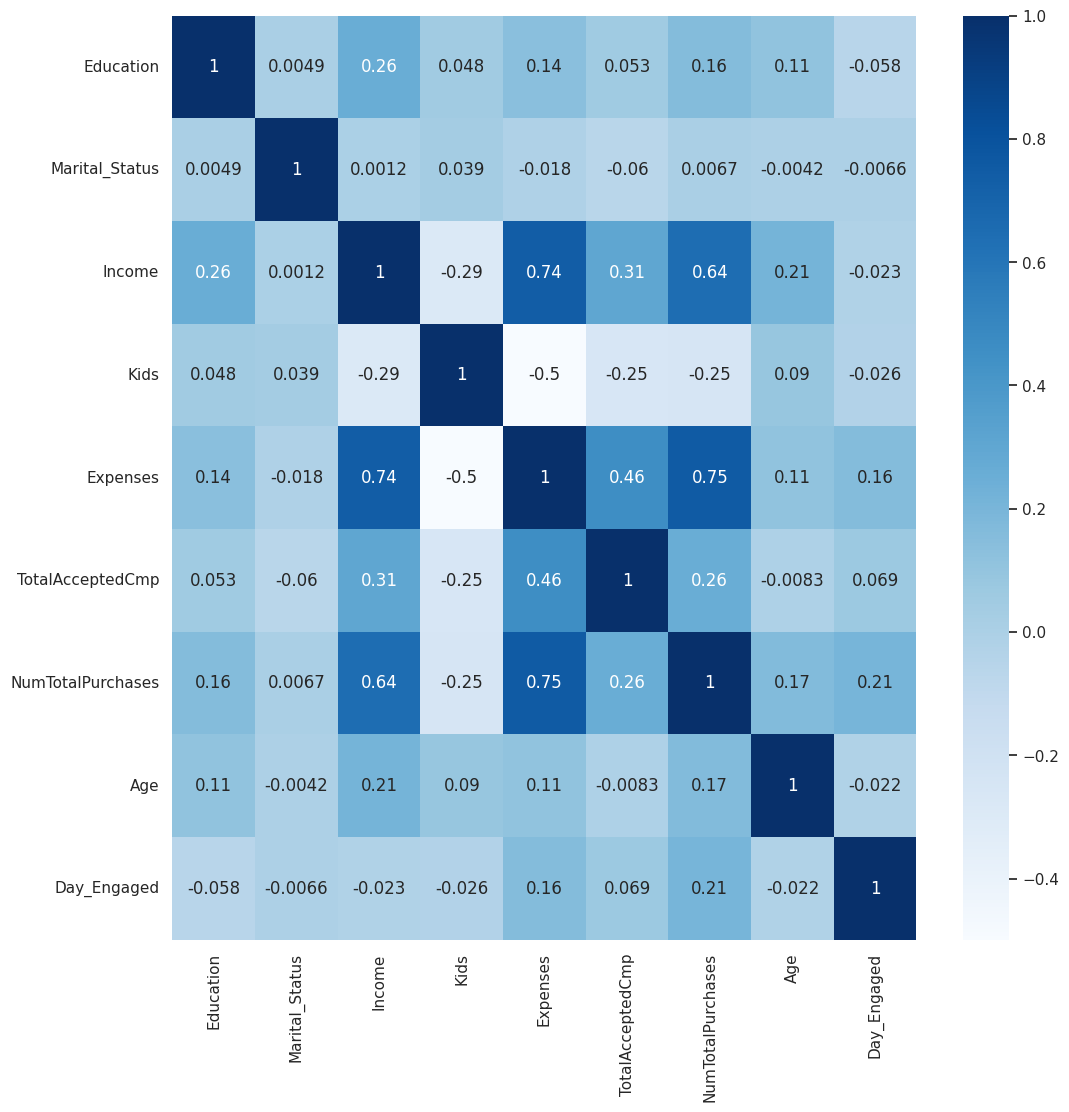

In [42]:
plt.figure(figsize = (12, 12))
sns.heatmap(min_df.corr(), annot = True, cmap = 'Blues')
plt.show()

Quan sát biểu đồ trên, ta thấy không có cặp 2 thuộc tính nào có quá nhiều sự tương quan với nhau nên ta không thể bỏ bất kỳ cột nào trong tập dữ liệu. Như vậy, dữ liệu hiện tại có vẻ ổn để sẵn sàng đưa vào các mô hình học máy. 

# E. XÂY DỰNG MÔ HÌNH HỌC MÁY

### Bài toán cần giải quyết là gì?

Mục tiêu của bài toán đưa ra là phân cụm các khách hàng này thành các phân khúc khách hàng khác nhau dựa theo tính cách và thói quen mua sắm, từ đó chọn ra nhóm khách hàng tiềm năng để gia tăng tiếp thị sản phẩm mới.

### Có những giả thuyết nào để giải quyết bài toán?

Các giả thuyết có thể để giải quyết bài toán: 
- K-Means - thuật toán gom cụm dựa vào điểm trung tâm
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise) - thuật toán gom cụm dựa trên mật độ
- OPTICS (Ordering Points To Identify Cluster Structure) - thuật toán gom cụm cải tiến của DBSCAN
- Agglomerative Clustering - thuật toán gom cụm phân cấp sử dụng chiến lược dưới lên (bottom up)
- BIRCH (Balanced Iterative Reducing and Clustering Using Hierarchies) - thuật toán gom cụm phân cấp sử dụng chiến lược gom cụm trên xuống (top down)
- SOM (Self-Organizing Map) - thuật toán gom cụm sử dụng mạng neural

Trong nội dung tìm hiểm, nhóm sẽ thử nghiệm với các loại mô hình sau: K-Means, DBSCAN, BIRCH

### Thiết kế mô hình học máy

Đầu tiên, ta sẽ xem lại bộ dữ liệu sau khi đã qua bước tiền xử lý.

In [43]:
min_df.head()

,Education,Marital_Status,Income,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Day_Engaged
0,0.157171,-1.346874,0.365968,-1.264505,1.679417,0.621248,1.320826,0.985345,1.531185
1,0.157171,-1.346874,-0.140537,1.396361,-0.961275,-0.501912,-1.154596,1.235733,-1.190545
2,0.157171,0.742460,0.881184,-1.264505,0.282673,-0.501912,0.799685,0.317643,-0.205773
3,0.157171,0.742460,-1.174271,0.065928,-0.918094,-0.501912,-0.894025,-1.268149,-1.061881
4,0.157171,0.742460,0.372239,0.065928,-0.305254,-0.501912,0.539114,-1.017761,-0.953012


#### K-Means - thuật toán gom cụm dựa vào điểm trung tâm

Ta sẽ copy dữ liệu vào một dataframe mới là `X`.

In [44]:
X = min_df.copy()

Bước đầu tiên ta cần phải xác định số nhóm cần gom cụm. Do đó, ta sử dụng phương pháp Elbow để tìm số k (số cluster) phù hợp nhất để xây dựng mô hình. Ta sẽ vẽ biểu đồ đường về hàm biến dạng Elbow để nhìn ra sự suy giảm của hàm biến dạng và lựa chọn ra điểm khuỷ tay (elbow point). Trong đó:
- Trục hoành: thể hiện số k (từ 1 đến 10).
- Trục tung: độ biến dạng theo từng số k.

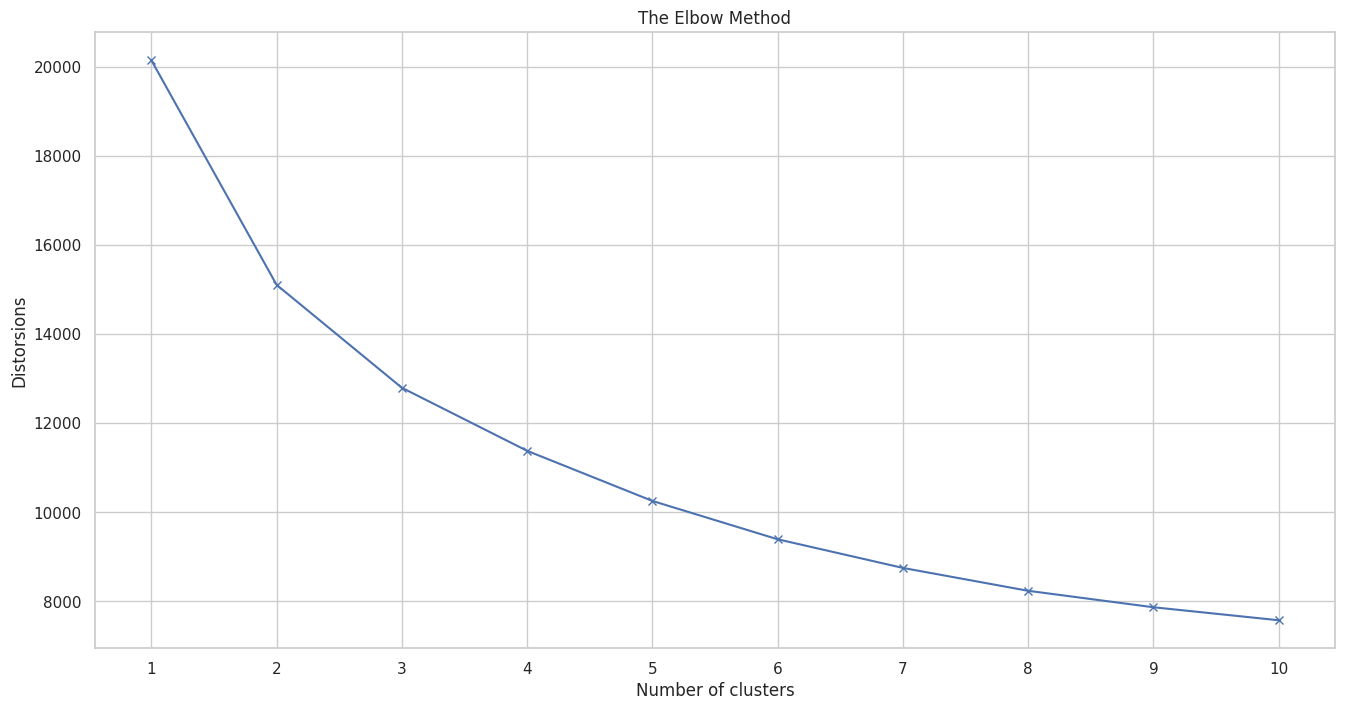

In [45]:
distorsions = []
for i in range (1, 11):
 kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
 kmeans.fit(X)
 distorsions.append(kmeans.inertia_)
plt.figure(figsize = (16, 8))
plt.plot(range(1, 11), distorsions, 'bx-')
plt.xticks(range(1, 11))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distorsions')
plt.show()

Quan sát biểu đồ trên, chúng ta không tìm thấy một điểm khủy tay nào phù hợp để chia cụm dữ liệu.

Do đó, ta sẽ tiếp tục sử dụng phương pháp tính độ đo Silhouette theo từng số k được thử để tìm số k tốt nhất cho mô hình gom cụm. Ta sẽ vẽ biểu đồ cột để thể hiện độ đo Silhouette theo từng số k. Trong đó:
- Trục hoành: thể hiện số k (từ 2 đến 10).
- Trục tung: độ đo Silhouette theo từng số k.



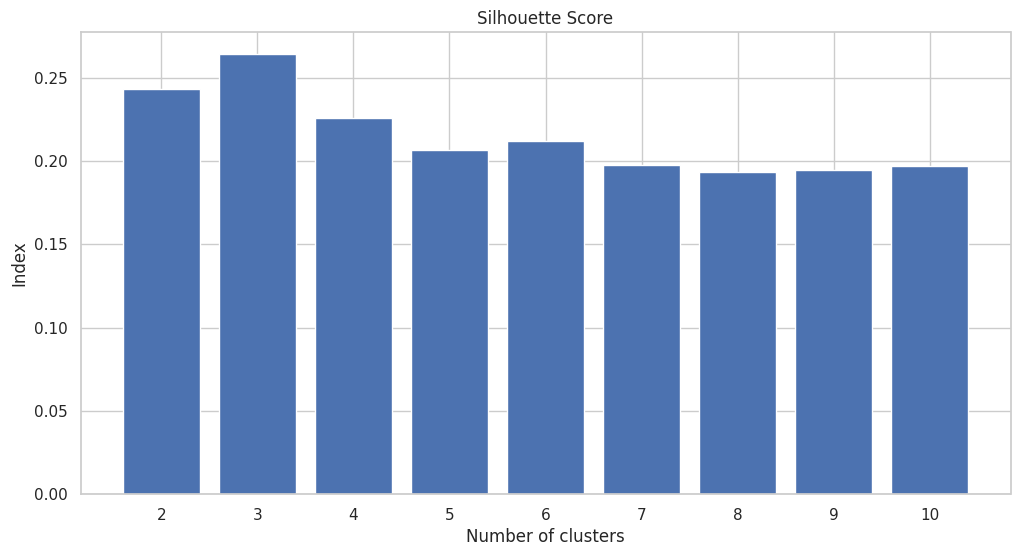

In [46]:
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  silhouette_scores.append(silhouette_score(X, kmeans.fit_predict(X)))
plt.figure(figsize = (12, 6))
plt.bar(range(2, 11), silhouette_scores)
plt.xticks(range(2, 11))
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Index')
plt.show()

Quan sát biểu đồ trên, chúng ta có thể tương ứng tại **k = 3** có độ đo Silhouette tốt nhất. Do đó **k = 3** có thể được xem là 1 giá trị tốt của mô hình K-Means để gom cụm dữ liệu.

Tiếp theo, chúng ta sẽ huấn luyện mô hình K-Means với 3 cụm trên bộ dữ liệu ở trên và tìm các điểm trung tâm gom cụm.

In [47]:
# Xây dựng mô hình K-means
model = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
model_fit = model.fit(X)

# Gán cụm cho tập dữ liệu
X['cluster'] = model.labels_

# Tìm các điểm trung tâm gom cụm
print('Cluster centers:')
print(model.cluster_centers_)

Cluster centers:
[[-6.36250591 -0.03136765 -1.63248304 -0.30363702 -0.87026906 -0.33551825
  -1.02189788 -0.72255025  0.36927219]
 [ 0.15717078  0.03070862 -0.60547905  0.43368053 -0.75618403 -0.31107955
  -0.70085484 -0.12027202 -0.14514779]
 [ 0.15717078 -0.03453085  0.80202971 -0.49516219  0.938744    0.38497018
   0.88164881  0.18075725  0.15131519]]


Sau đó, ta sẽ thực hiện phương pháp PCA để giảm chiều dữ liệu về 2 chiều rồi trực quan hóa bằng biểu đồ scatter để thể hiện các gom cụm của dữ liệu. Trong đó:
- Trục tung: thể hiện cho component 1.
- Trục hoành: thể hiện cho component 2.

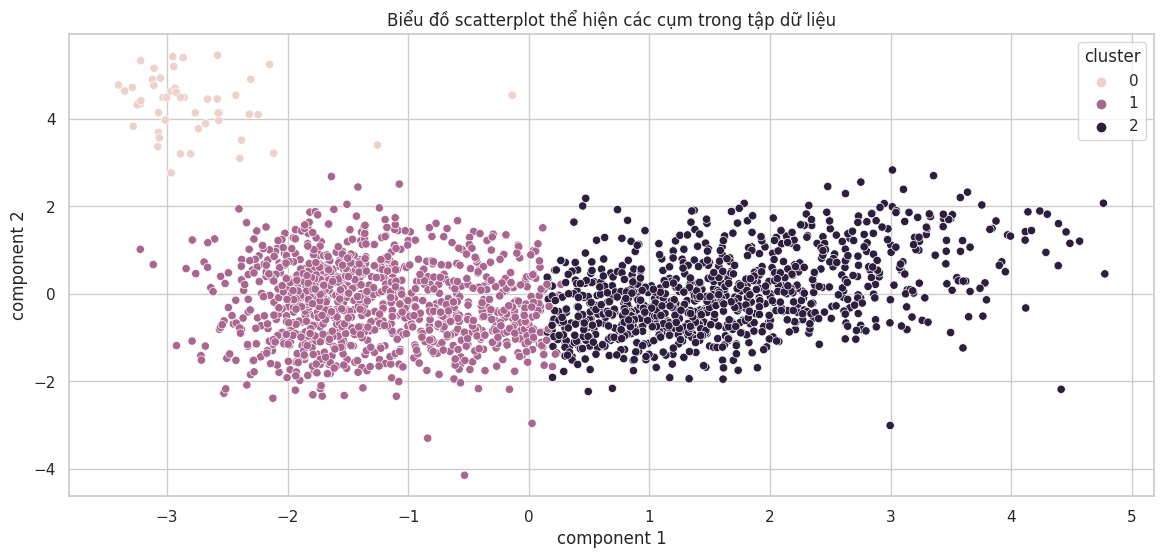

In [48]:
# Giảm chiều dữ liệu
pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(X[X.columns.drop(['cluster'])]), columns = ['component 1', 'component 2'])
pca_df['cluster'] = X['cluster']

# Vẽ biểu đồ trực quan hóa
plt.figure(figsize = (14, 6))
sns.scatterplot(data = pca_df, x = 'component 1', y = 'component 2', hue = 'cluster').set_title('Biểu đồ scatterplot thể hiện các cụm trong tập dữ liệu')
plt.show()

Quan sát biểu đồ trên, ta thấy dữ liệu đa được gom cụm thành 3 nhóm riêng biệt. Trong đó nhóm 0 nằm riêng biệt hẳn so với nhóm 1 và nhóm 2 được chia thành 2 phía của biểu đồ.

Sau đó ta sẽ vẽ biểu độ cột để thể hiện số lượng khách hàng theo từng các cụm. Trong đó:
- Màu xanh dương: thể hiện cho cụm 0.
- Màu cam: thể hiện cho cụm 1.
- Màu xanh lá: thể hiện cho cụm 2.

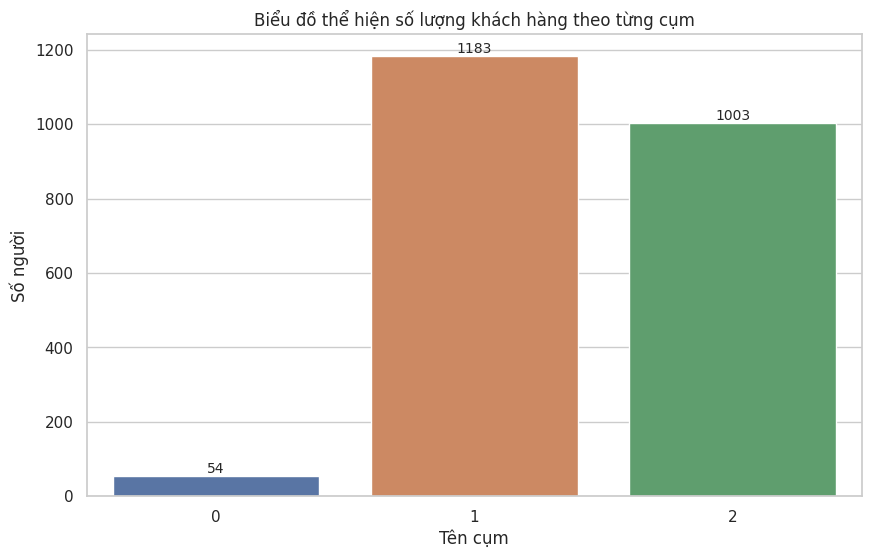

In [49]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(data = X, x = 'cluster', ax = ax)
ax.bar_label(ax.containers[0], fontsize = 10)
plt.title('Biểu đồ thể hiện số lượng khách hàng theo từng cụm')
plt.xlabel('Tên cụm')
plt.ylabel('Số người')
plt.show()

Quan sát biểu đồ trên, ta thấy số lượng khách thuộc **cụm 1** chiếm nhiều nhất, sau đó tới **cụm 2** và cuối cùng số lượng khách thuộc **cụm 0** chiếm ít nhất.

Cuối cùng, ta sẽ vẽ các biểu đồ histogram thể hiện phân phối của từng thuộc tính theo từng cụm. Trong đó:
- Màu đỏ: thể hiện cho cụm 0.
- Màu xanh lá: thể hiện cho cụm 1.
- Màu xanh dương: thể hiện cho cụm 2.

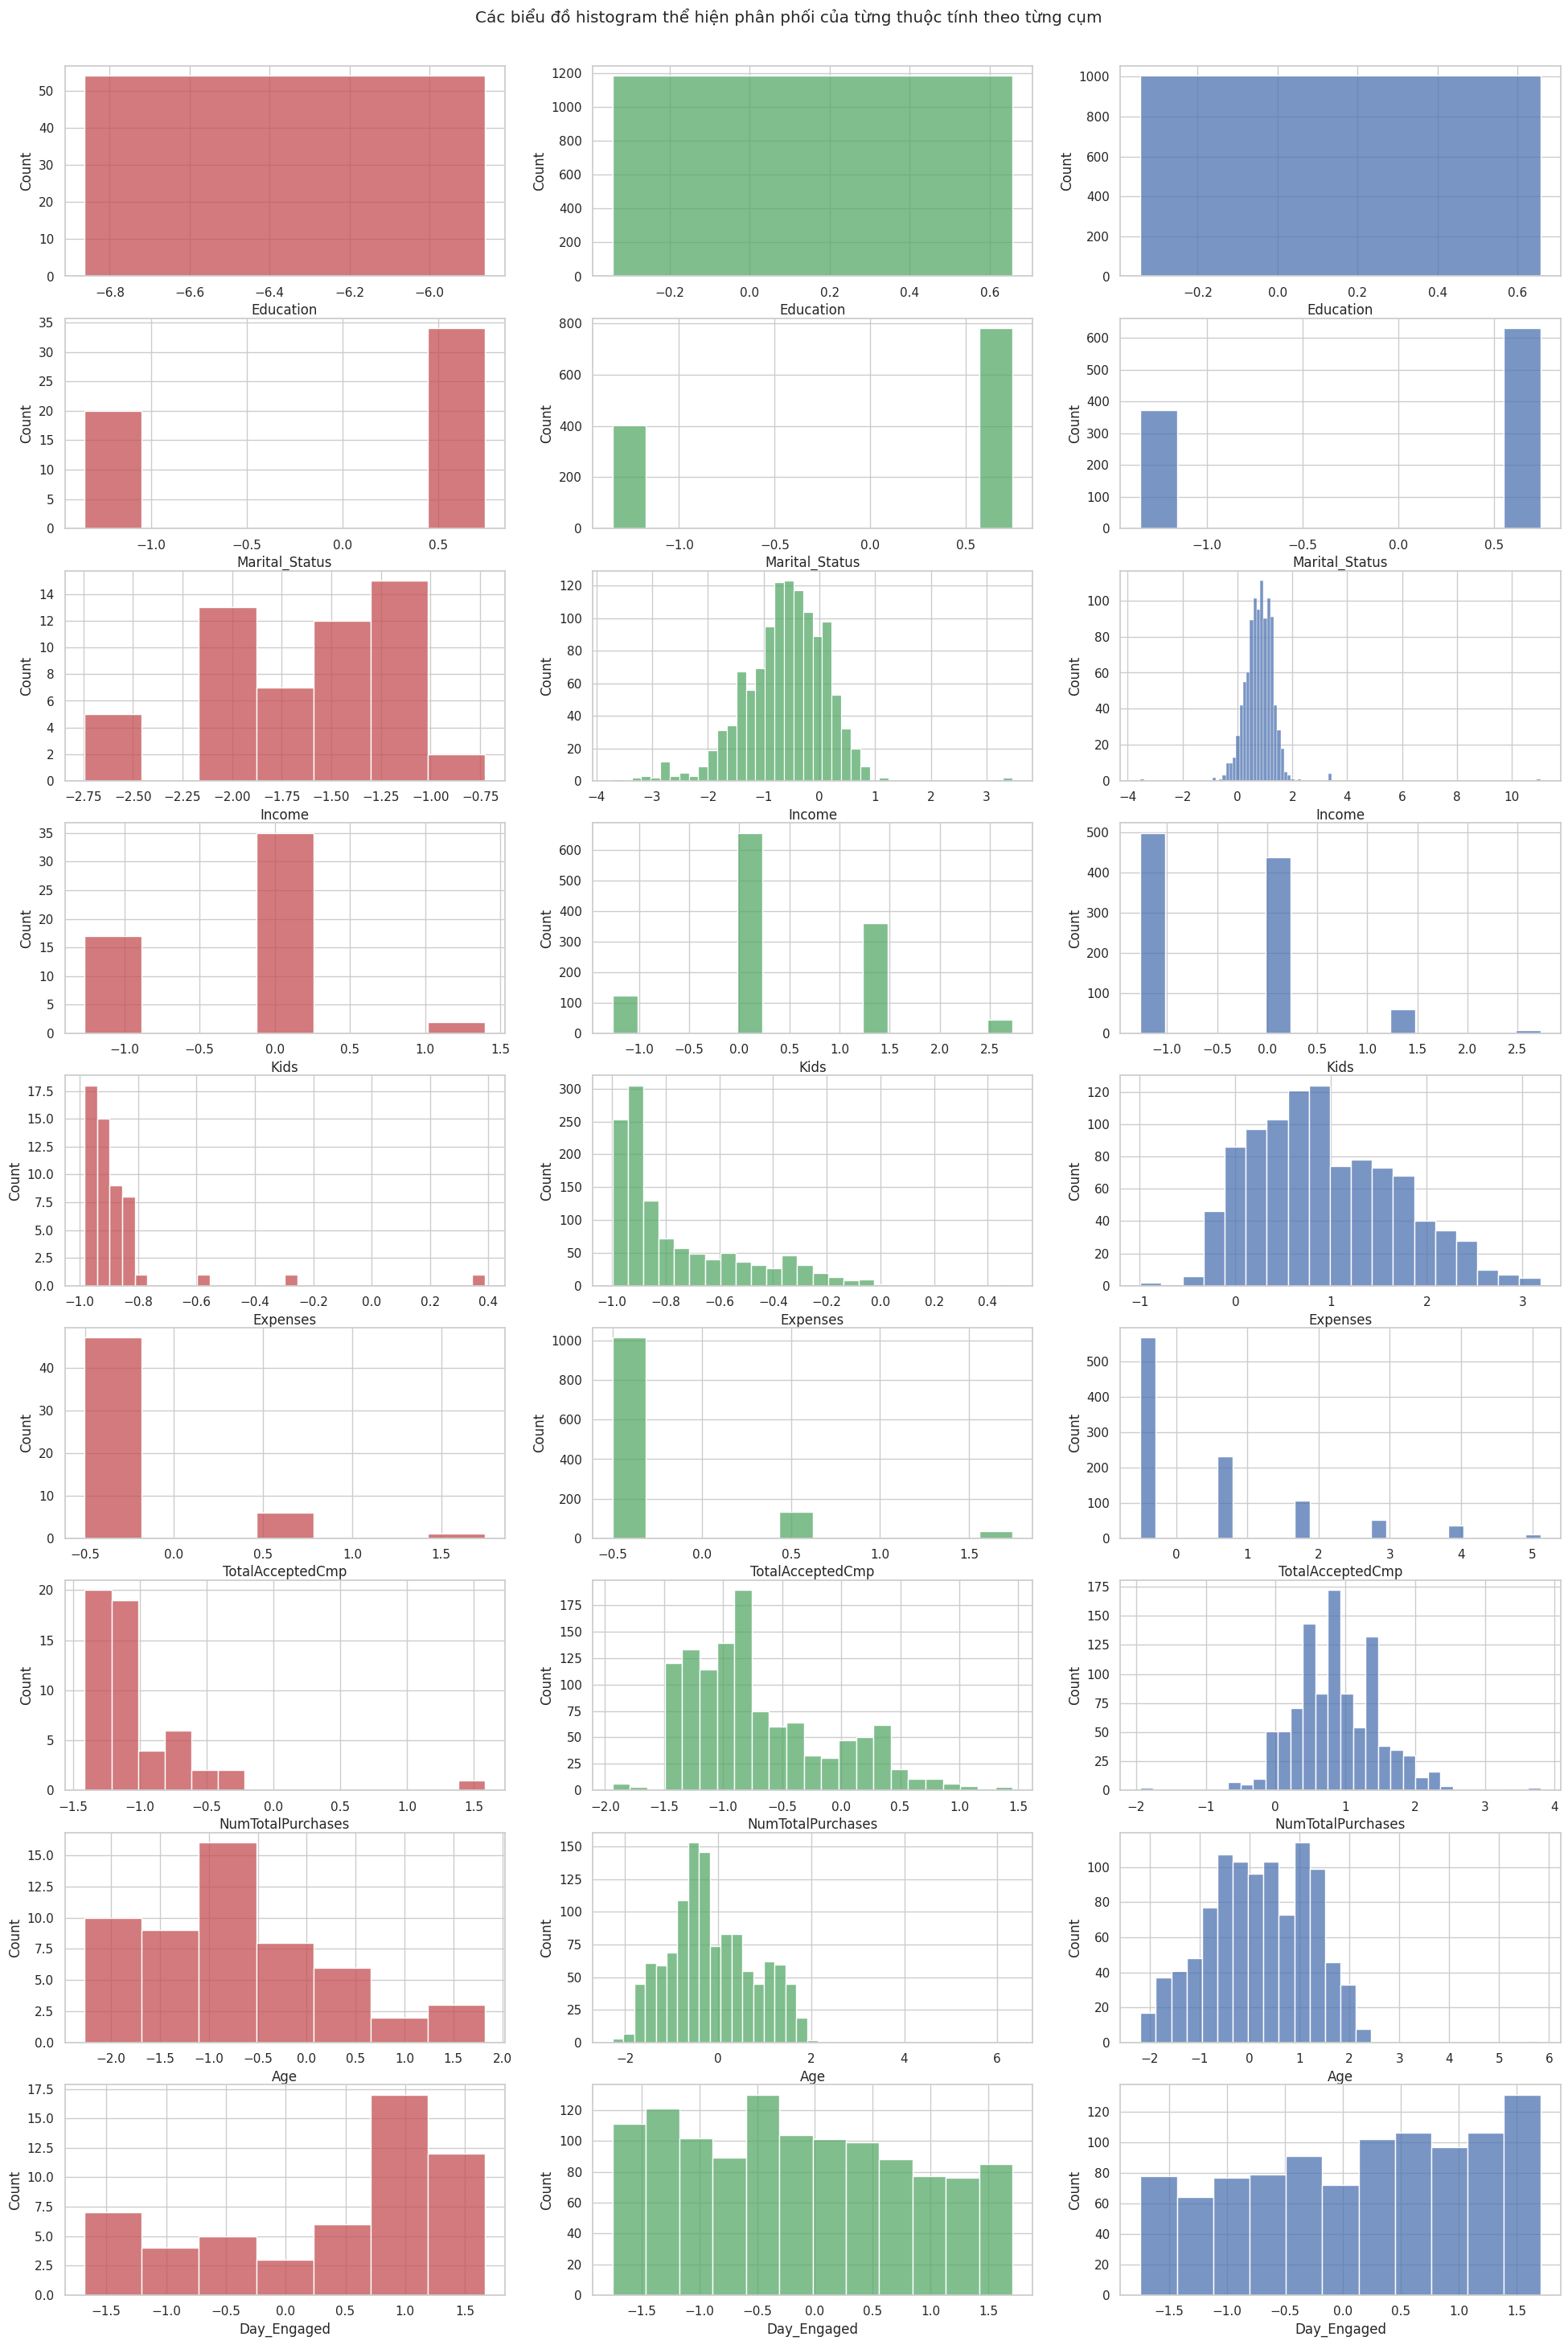

In [50]:
X_0 = X[X['cluster'] == 0]
X_1 = X[X['cluster'] == 1]
X_2 = X[X['cluster'] == 2]

fig, axs = plt.subplots(9, 3, figsize = (24, 36))
idx = 0
for i in min_df.columns:
    sns.histplot(X_0[i], ax = axs[idx, 0], color = 'r')
    sns.histplot(X_1[i], ax = axs[idx, 1], color = 'g')
    sns.histplot(X_2[i], ax = axs[idx, 2], color = 'b')
    idx += 1
plt.suptitle('Các biểu đồ histogram thể hiện phân phối của từng thuộc tính theo từng cụm', y = 0.9)
plt.show()

**Nhận xét:** Quan sát các biểu đồ trên, ta có thể biết được các thông tin sau:
- Dựa trên việc phân cụm có thể chia thành 3 nhóm khách hàng sau: khách hàng tích cực (những khách hàng thuộc cụm 2), khách hàng hoạt động vừa phải (những khách hàng thuộc cụm 1) và khách hàng ít hoạt động nhất (những khách hàng thuộc cụm 0).
- Đặc điểm của nhóm khách hàng tích cực (cụm 2): độ tuổi **từ 25 đến 75** và có độ tuổi tối đa **từ 40 đến 50**, có trình độ học vấn đến từ **PG**, khoảng gấp đôi những người này có tình trạng hôn nhân là kết hôn so với độc thân, có thu nhập cao hơn nhóm khách hàng hoạt động vừa phải, trung bình hộ gia đình có **1 đứa con**, chi tiêu trung bình khoảng **100-200** cho các lần mua hàng, số ngày hoạt động cũng **tích cực** hơn nên thường họ sẽ gắn bó với công ty lâu dài hơn.
- Đặc điểm của nhóm khách hàng hoạt động vừa phải (cụm 1): độ tuổi **từ 25 đến 75** và có độ tuổi tối đa **từ 35 đến 60**, cũng có trình độ học vấn đến từ **PG**, khoảng gấp đôi những người này có tình trạng hôn nhân là kết hôn so với độc thân, có thu nhập không bằng nhóm khách hàng hoạt động tích cực (đa phần đều không có con), chi tiêu trung bình khoảng **500-2000** cho các lần mua hàng, và khách hàng hoạt động vừa phải **ít tương tác** hơn một chút so với nhóm khách hàng tích cực.
- Đặc điểm của nhóm khách hàng ít hoạt động (cụm 0): độ tuổi **từ 15 đến 30**, có trình độ học vấn đến từ **UG**, đa phần những người này đều **độc thân**, có thu nhập **rất ít** hoặc không đáng kể (do chưa có công việc ổn định), chỉ một vài trong số những người này có con, chi tiêu cho các lần mua hàng **khá ít** hoặc không đáng kể, và khách hàng ít hoạt động **không tương tác** nhiều đến công ty.

#### DBSCAN - thuật toán gom cụm dựa trên mật độ

Ta sẽ copy dữ liệu vào một dataframe mới là `X`.

In [51]:
X = min_df.copy()

Bước đầu tiên, ta cần phải xác định các tham số phù hợp cho mô hình DBSCAN (Density-Based Spatial Clustering of Applications with Noise). Ở đây có 2 tham số cần quan tâm:
- `minPts`: theo quy tắc chung thì thường chọn `minPts = 2 x dim`. Trong trường hợp dữ liệu có nhiễu hoặc có nhiều quan sát lặp lại thì cần lựa chọn giá trị lớn hơn nữa tương ứng với những bộ dữ liệu lớn.
- `epsilon`: được xuất hiện trong biểu đồ thể hiện khoảng cách của thuật toán K-Means đến điểm láng giềng gần nhất. Giá trị được `epsilon` là tốt nhất khi có xuất hiện điểm khủy tay (elbow point).

Đối với tham số đầu tiên `minPts` ta thấy dữ liệu có 9 chiều, do đó ta sẽ chọn tham số `minPts = 19` theo quy tắc trên để sử dụng cho việc vẽ biểu đồ k-distance. Tiếp theo, ta sẽ vẽ biểu đồ k-distance thể hiện giá trị khoảng cách trong thuật toán gom cụm K-Means đến điểm láng giềng gần nhất. Trong đó:
- Trục hoành: thể hiện các index.
- Trục tung: thể hiện khoảng cách tương ứng, giả định ở đây ta sử dụng phương pháp tính khoảng cách Euclidean.

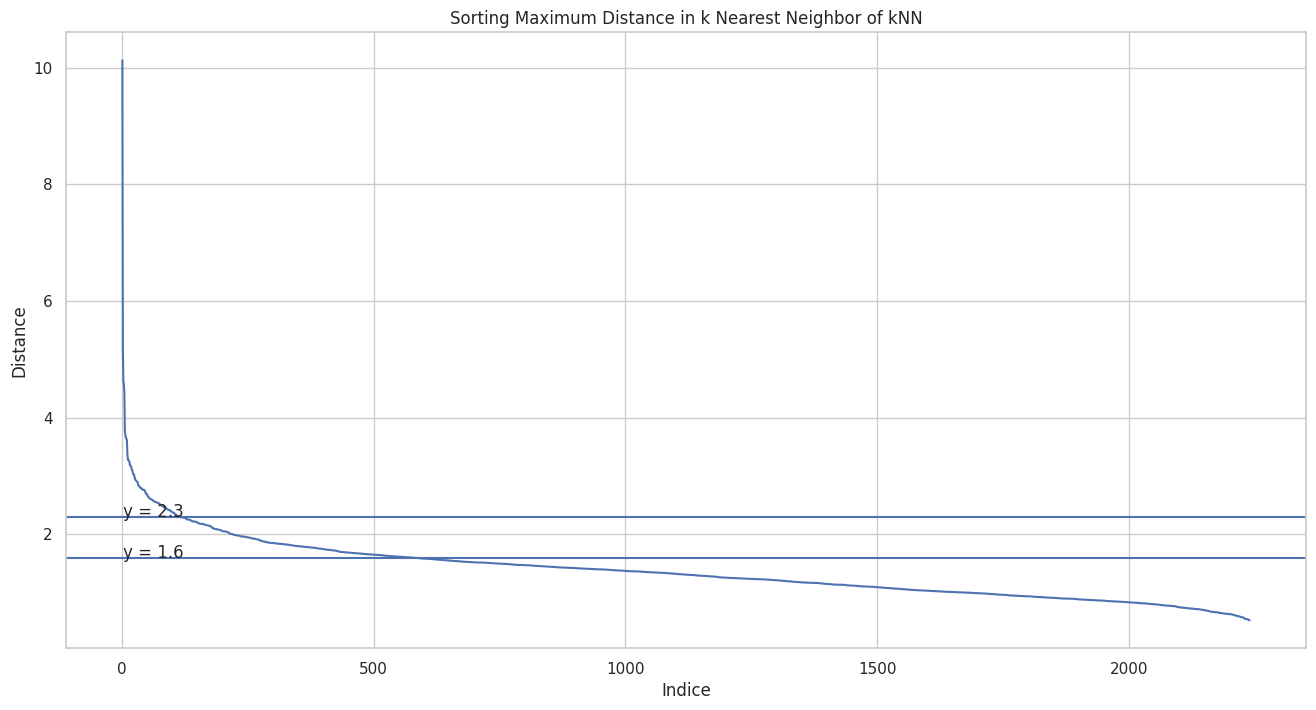

In [52]:
# Xây dựng mô hình K-Means với k = 19
neighbors = 19
nbrs = NearestNeighbors(n_neighbors = neighbors).fit(X)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(X)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần
distance_desc = sorted(distances[:, neighbors - 1], reverse = True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize = (16, 8))
plt.plot(list(range(1, len(distance_desc) + 1)), distance_desc)
plt.axhline(y = 1.6)
plt.text(2, 1.6, 'y = 1.6', fontsize = 12)
plt.axhline(y = 2.3)
plt.text(2, 2.3, 'y = 2.3', fontsize = 12)
plt.ylabel('Distance')
plt.xlabel('Indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')
plt.show()

Từ biểu đồ k-distance chúng ta có thể thấy điểm elbow tương ứng nằm trong khoảng **từ 1.6 đến 2.3**. Tiếp theo chúng ta sẽ tìm kiếm giá trị của tham số `epsilon` trong khoảng này cho mô hình DBSCAN. Tham số `minPts` được cố định là **19** như lúc đầu lựa chọn.

Tiếp theo, ta sẽ thực hiện phương pháp t-SNE để giảm chiều dữ liệu về 2 chiều rồi gán vào dataframe mới `X_new`. Sau đó ta sẽ vẽ biểu đồ các scatter thể hiện các các cụm trong tập dữ liệu dựa theo các giá trị `epsilon` khác nhau. Trong đó:
- Trục tung: thể hiện cho component 1.
- Trục hoành: thể hiện cho component 2.

Theo đó, các màu sắc thể hiện cho việc phân cụm các mẫu.

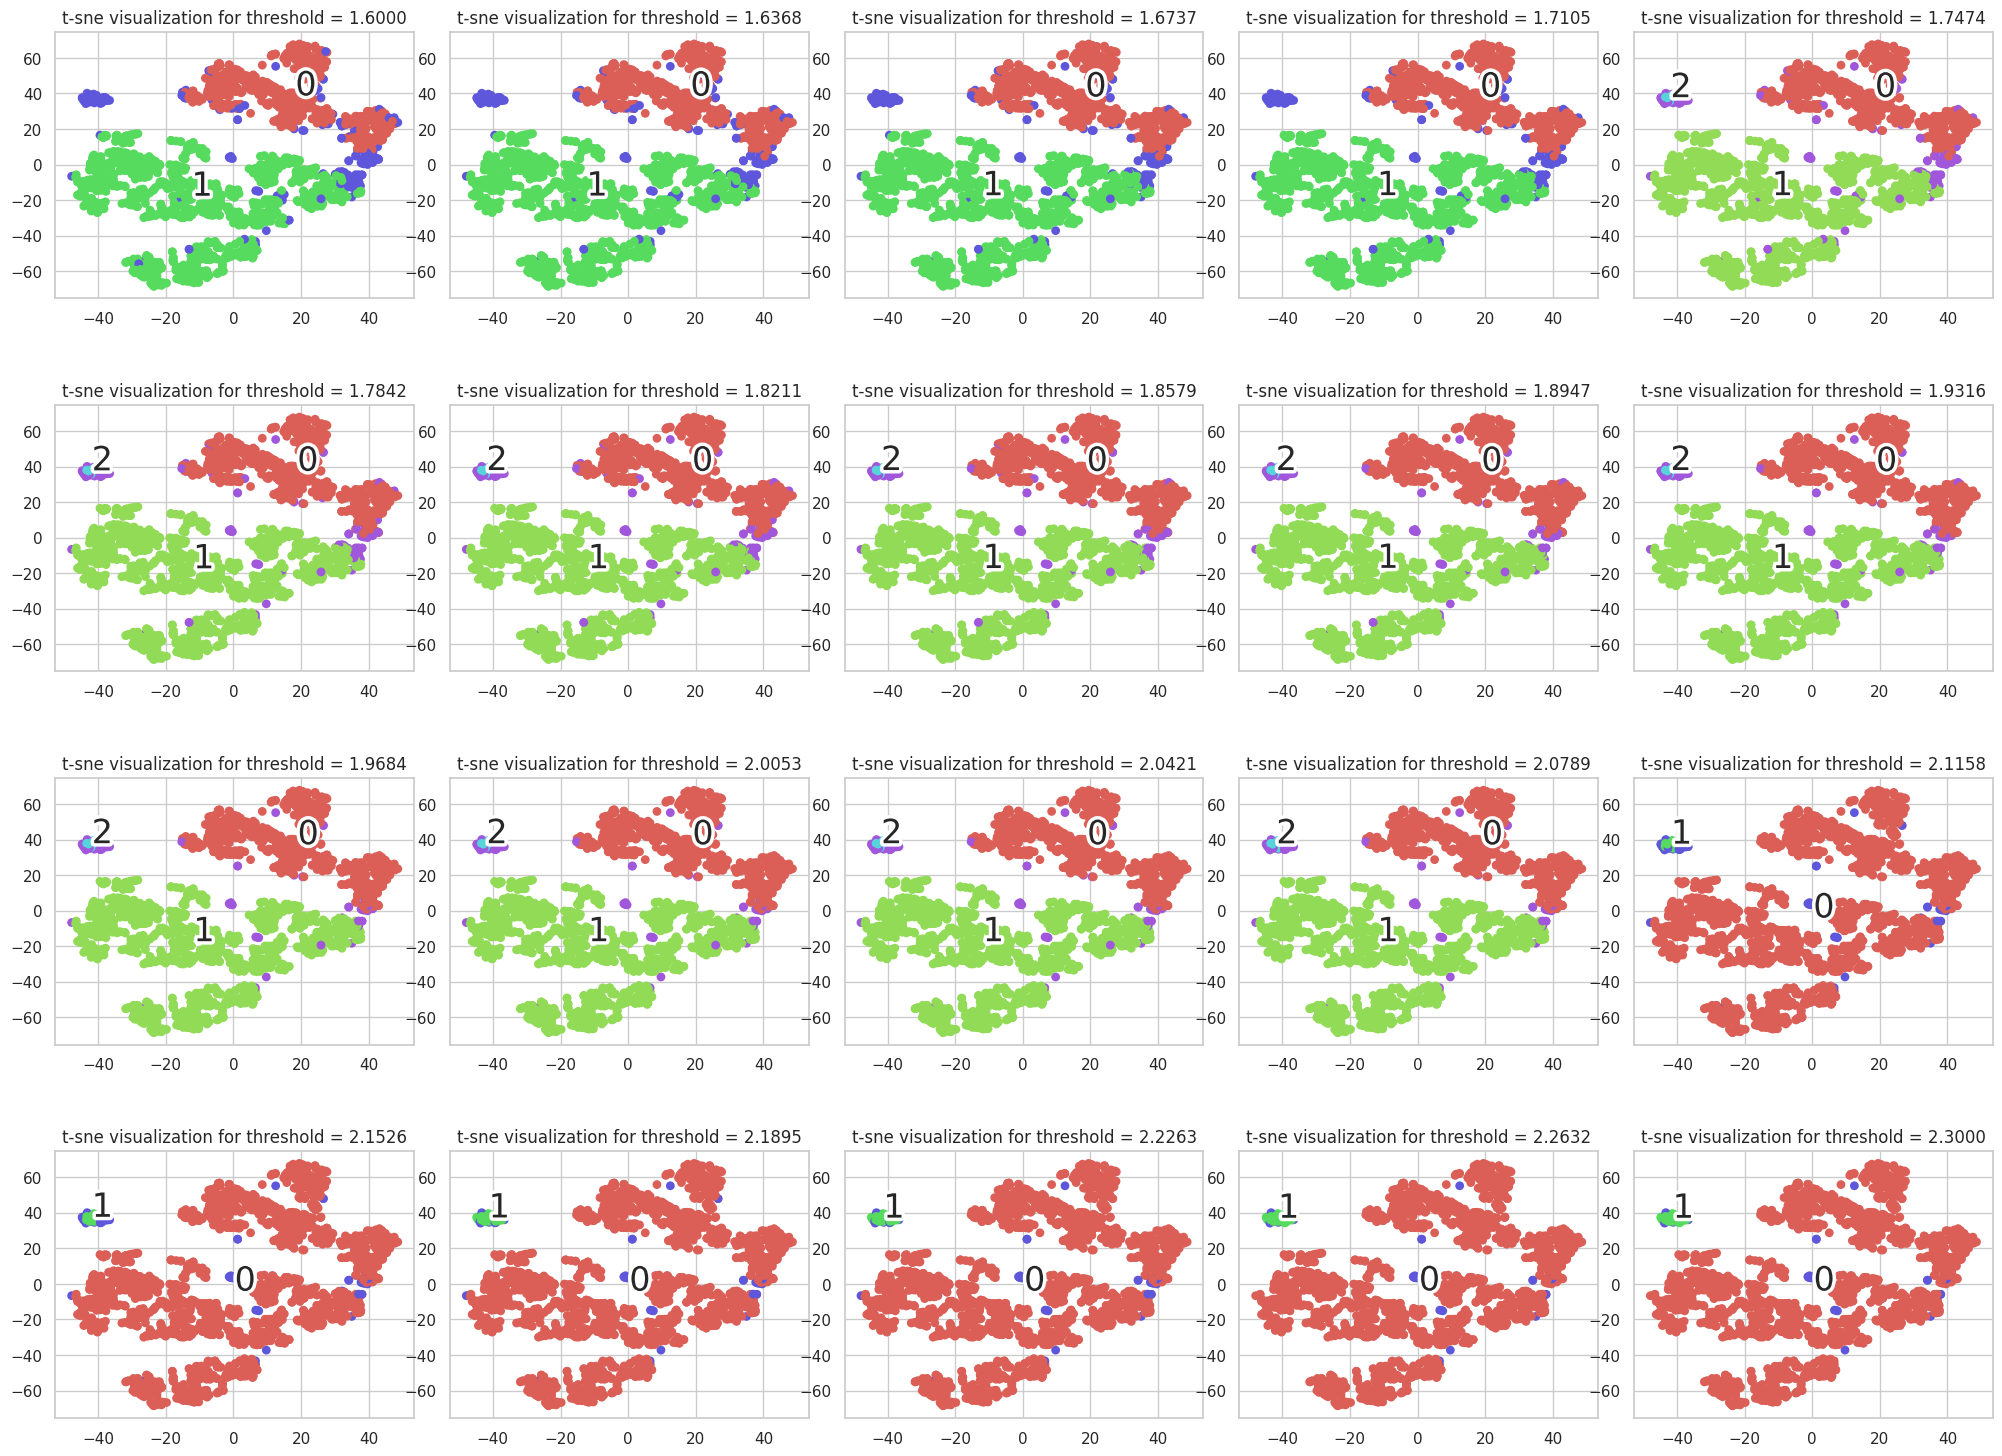

In [53]:
# Giảm chiều dữ liệu
tsne = TSNE(n_components = 2)
X_new = tsne.fit_transform(X)

# Hàm vẽ biểu đồ k-distance
def plot_kmean_scatter(X, labels, gs, threshold):
  # Lựa chọn màu sắc
  num_classes = len(np.unique(labels))
  palette = np.array(sns.color_palette('hls', num_classes))

  # Vẽ biểu đồ scatter
  ax = plt.subplot(gs)
  sc = ax.scatter(X[:, 0], X[:, 1], lw = 0, s = 40, c = palette[labels.astype(int)])

  # Thêm nhãn cho mỗi cluster
  txts = []

  for i in range(num_classes):
    # Vẽ text tên cụm tại trung vị của mỗi cụm
    indices = (labels == i)
    xtext, ytext = np.median(X[indices, :], axis = 0)
    if not (np.isnan(xtext) or np.isnan(ytext)):        
      txt = ax.text(xtext, ytext, str(i), fontsize = 24)
      txt.set_path_effects([PathEffects.Stroke(linewidth = 5, foreground = "w"), PathEffects.Normal()])
      txts.append(txt)
    plt.title('t-sne visualization for threshold = {:.4f}'.format(threshold))

gs = GridSpec(4, 5)
plt.figure(figsize = (25, 18))
plt.subplots_adjust(wspace = 0.1, hspace = 0.4)
for i, threshold in enumerate(np.linspace(1.6, 2.3, 20)):
  # Xây dựng mô hình DBSCAN
  dbscan = DBSCAN(eps = threshold, min_samples = 19, metric = 'euclidean')
  labels = dbscan.fit_predict(X)

  # Trực quan hóa biểu đồ
  plot_kmean_scatter(X_new, labels, gs[i], threshold)

Quan sát các biểu đồ trên, chúng ta có thể lựa chọn `epsilon = 1.8947` là giá trị mà các cụm có vẻ mang lại kết quả gom cụm hiệu quả nhất.

Sau đó, ta sẽ thực hiện lại việc xây dựng mô hình DBSCAN với giá trị `epsilon = 1.8947` và gán cụm cho tập dữ liệu mới.

In [54]:
# Xây dựng mô hình DBSCAN
dbscan = DBSCAN(eps = 1.8947, min_samples = 19, metric = 'euclidean')

# Gán cụm cho tập dữ liệu
X['cluster'] = dbscan.fit_predict(X)

Tiếp theo, ta sẽ vẽ biểu độ cột để thể hiện số lượng khách hàng theo từng các cụm. Trong đó:
- Màu xanh dương: thể hiện cho cụm -1.
- Màu cam: thể hiện cho cụm 0.
- Màu xanh lá: thể hiện cho cụm 1.
- Màu đỏ: thể hiện cho cụm 2.

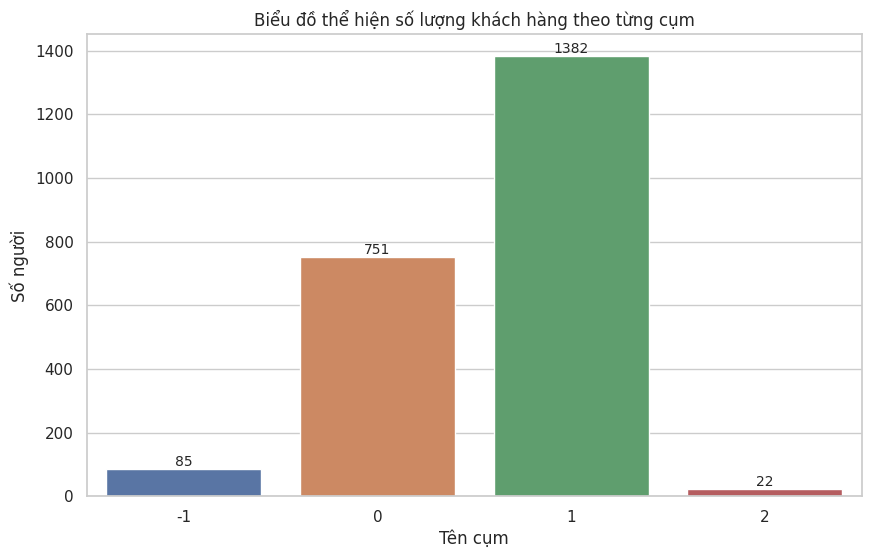

In [55]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(data = X, x = 'cluster', ax = ax)
ax.bar_label(ax.containers[0], fontsize = 10)
plt.title('Biểu đồ thể hiện số lượng khách hàng theo từng cụm')
plt.xlabel('Tên cụm')
plt.ylabel('Số người')
plt.show()

Quan sát biểu đồ trên, ta thấy thuật toán DBSCAN chia tập dữ liệu này thành 4 cụm khác nhau so với thuật toán K-Means chỉ chia thành 3 cụm. Trong đó cụm **1** chiếm nhiều nhất, sau đó tới cụm **2** ít hơn một nửa so với cụm **1**. Hai cụm còn lại chiếm ít nhất là cụm **-1** với **85** mẫu và cụm **2** với **22** mẫu. Tuy nhiên, trong đó cụm **-1** là cụm có chứa các điểm nhiễu.

Tương tự như trên, cuối cùng ta sẽ vẽ các biểu đồ histogram thể hiện phân phối của từng thuộc tính theo từng cụm. Trong đó:
- Màu cam: thể hiện cho cụm -1.
- Màu đỏ: thể hiện cho cụm 0.
- Màu xanh lá: thể hiện cho cụm 1.
- Màu xanh dương: thể hiện cho cụm 2.

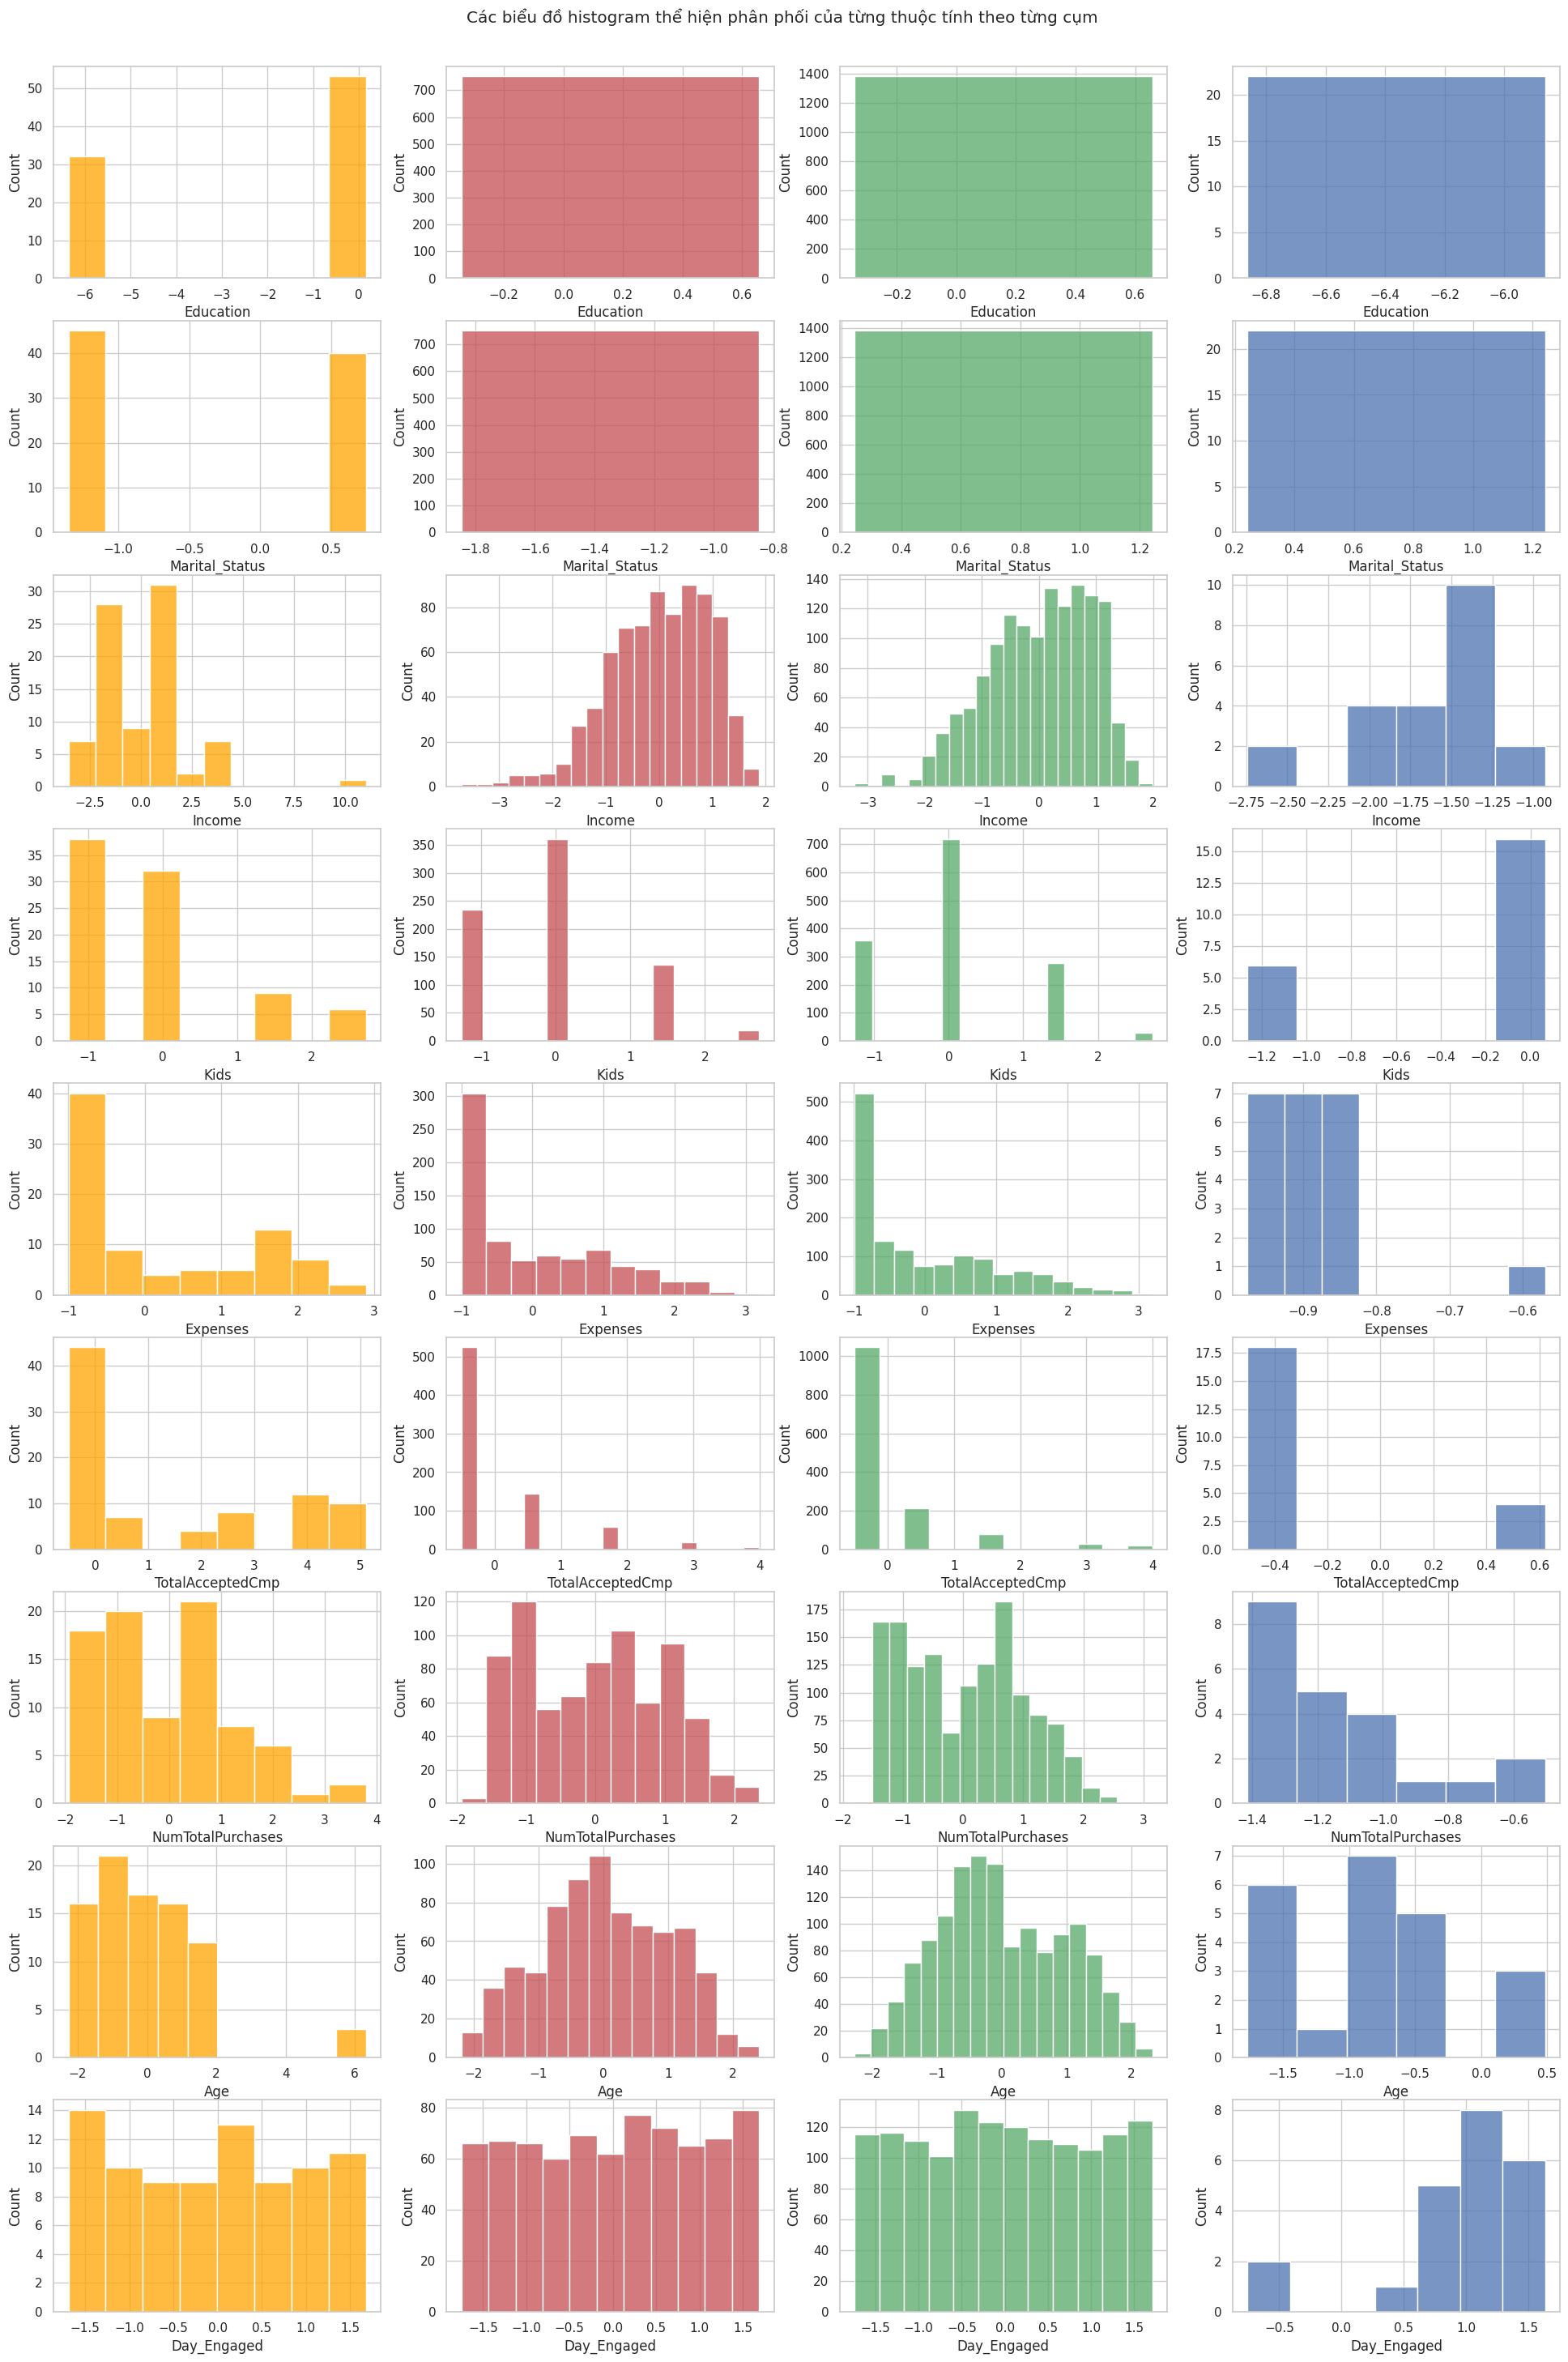

In [56]:
_X_1 = X[X['cluster'] == -1]
X_0 = X[X['cluster'] == 0]
X_1 = X[X['cluster'] == 1]
X_2 = X[X['cluster'] == 2]

fig, axs = plt.subplots(9, 4, figsize = (24, 36))
idx = 0
for i in min_df.columns:
    sns.histplot(_X_1[i], ax = axs[idx, 0], color = 'orange')
    sns.histplot(X_0[i], ax = axs[idx, 1], color = 'r')
    sns.histplot(X_1[i], ax = axs[idx, 2], color = 'g')
    sns.histplot(X_2[i], ax = axs[idx, 3], color = 'b')
    idx += 1
plt.suptitle('Các biểu đồ histogram thể hiện phân phối của từng thuộc tính theo từng cụm', y = 0.9)
plt.show()

**Nhận xét:** Quan sát các biểu đồ trên, ta có thể biết được các thông tin sau:
- Dựa trên việc phân cụm có thể chia thành 4 nhóm khách hàng sau: khách hàng là người độc thân (những khách hàng thuộc cụm 0), khách hàng là người kết hôn (những khách hàng thuộc cụm 1), khách hàng hoạt động vừa phải (những khách hàng thuộc cụm -1) và khách hàng ít hoạt động nhất (những khách hàng thuộc cụm 2).
- Đặc điểm của nhóm khách hàng là người độc thân (cụm 1): độ tuổi **từ 25 đến 75**, có trình độ học vấn đến từ **PG**, có tình trạng hôn nhân là **độc thân**, có thu nhập cao và số ngày hoạt động tương tự nhóm khách hàng là người đã kết hôn (cụm 0), chi tiêu trung bình khoảng **100-500**.
- Đặc điểm của nhóm khách hàng là người kết hôn (cụm 0): độ tuổi **từ 25 đến 75**, có trình độ học vấn đến từ **PG**, có tình trạng hôn nhân là **đã kết hôn**, có thu nhập cao và số ngày hoạt động tương tự nhóm khách hàng là người độc thân (cụm 1), chi tiêu trung bình khoảng **200-1000**.
- Đặc điểm của nhóm khách hàng ít hoạt động (cụm 2): độ tuổi **từ 15 đến 30**, có trình độ học vấn đến từ **UG**, có tình trạng hôn nhân là **độc thân**, có thu nhập **rất ít** hoặc không đáng kể (do chưa có công việc ổn định), chi tiêu cho các lần mua hàng **khá ít** hoặc không đáng kể, và khách hàng ít hoạt động **không tương tác** nhiều đến công ty.
- Đặc điểm của nhóm khách hàng ít hoạt động vừa phải (cụm -1): độ tuổi **từ 25-50** và có độ tuổi tối đa **từ 40 đến 50**, khoảng gấp đôi những người này có trình độ học vấn đến cả từ **PG** so với **UG**, có cả tình trạng hôn nhân **đã kết hôn và độc thân**, số ngày hoạt động tương tự nhóm khách hàng đã kết hôn và độc thân, và có chi tiêu trung bình khoảng **200-1000**.

#### BIRCH - thuật toán gom cụm phân cấp

Ta sẽ copy dữ liệu vào một dataframe mới là `X`.

In [57]:
X = min_df.copy()

Bước đầu tiên, ta cần phải xác định các tham số phù hợp cho mô hình BIRCH (Balanced Iterative Reducing and Clustering Using Hierarchies) sử dụng chiến lược gom cụm trên xuống (top down). Ở đây có 2 tham số cần quan tâm:
- `n_clusters`: số cụm cần chia.
- `threshold`: khoảng cách giữa các điểm đủ điều kiện gom nhóm, giả định ở đây ta sử dụng phương pháp tính khoảng cách Euclidean để tính khoảng cách giữa các mẫu với nhau.

Đối với tham số đầu tiên `n_clusters`, ta cần phải xác định số nhóm cần gom cụm. Do đó, ta sẽ sử dụng phương pháp tính độ đo Calinski-Harabasz theo từng số k được thử để tìm số k tốt nhất cho mô hình gom cụm. Ta sẽ vẽ biểu đồ cột để thể hiện độ đo Calinski-Harabasz theo từng số k. Trong đó:
- Trục hoành: thể hiện số k (từ 2 đến 10).
- Trục tung: độ đo Calinski-Harabasz theo từng số k.

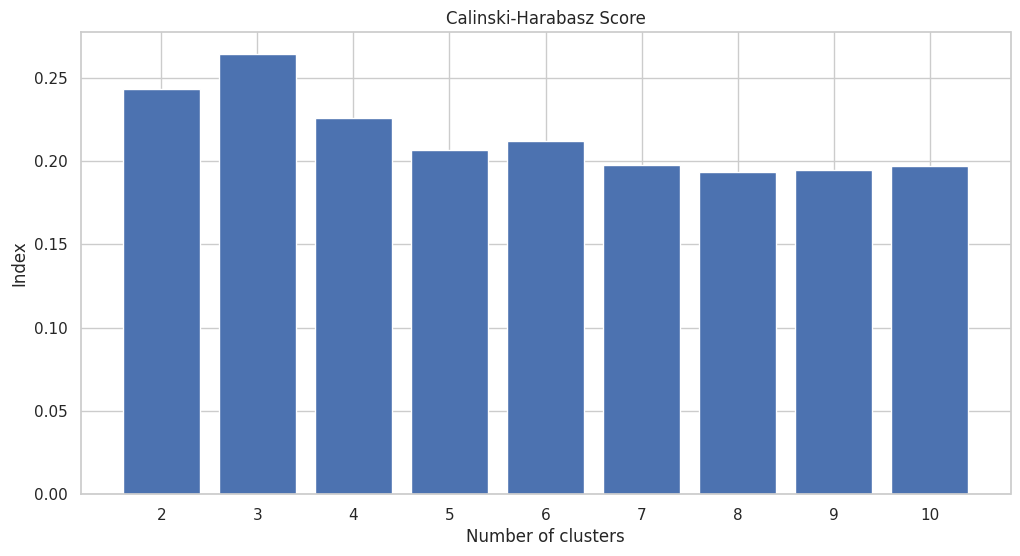

In [58]:
calinski_harabasz_scores = []
for i in range(2, 11):
  brc = Birch(n_clusters = i)
  calinski_harabasz_scores.append(calinski_harabasz_score(X, brc.fit_predict(X)))
plt.figure(figsize = (12, 6))
plt.bar(range(2, 11), silhouette_scores)
plt.xticks(range(2, 11))
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of clusters')
plt.ylabel('Index')
plt.show()

Quan sát biểu đồ trên, chúng ta có thể tương ứng tại **k = 3** có độ đo Calinski-Harabasz tốt nhất. Do đó **k = 3** có thể được xem là 1 giá trị tốt của mô hình BIRCH để gom cụm dữ liệu.

Tiếp theo, ta sẽ vẽ biểu đồ đường để thể hiện phân bố số mẫu thuộc cùng 1 cụm theo từng ngưỡng khác nhau. Trong đó:
- Trục hoành: thể hiện các giá trị ngưỡng `threshold` từ 0.1 đến 2.
- Trục tung: thể hiện số mẫu theo từng giá trị ngưỡng khác nhau.

Các màu sắc cũng thể hiện cho các cụm đã được chia bằng mô hình BIRCH. Trong đó:
- Màu đỏ: thể hiện cho cụm 0.
- Màu xanh lá: thể hiện cho cụm 1.
- Màu xanh dương: thể hiện cho cụm 2.

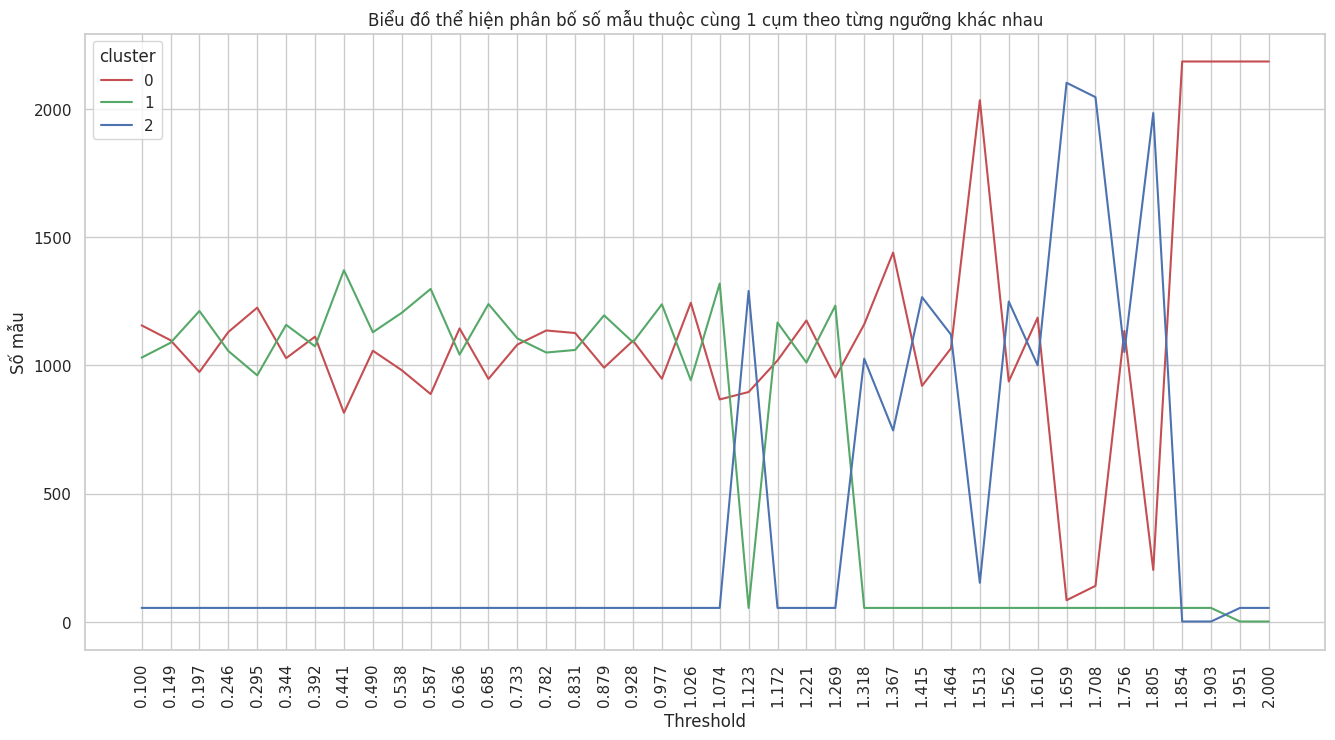

In [59]:
# Tính số lượng mẫu trong các cluster
prob_clusters = { 0: [], 1: [], 2: [] }
for i in np.linspace(0.1, 2, 40):
  brc = Birch(n_clusters = 3, threshold = i)
  labels = brc.fit_predict(X)
  unique, counts = np.unique(labels, return_counts = True)
  for c in unique:
    prob_clusters[c].append(counts[c])

# Vẽ biểu đồ trực quan hóa
plt.figure(figsize = (16, 8))
plt.plot(np.linspace(0.1, 2, 40), prob_clusters[0], color = 'r', label = '0')
plt.plot(np.linspace(0.1, 2, 40), prob_clusters[1], color = 'g', label = '1')
plt.plot(np.linspace(0.1, 2, 40), prob_clusters[2], color = 'b', label = '2')
plt.xticks(np.linspace(0.1, 2, 40), rotation = 90)
plt.title('Biểu đồ thể hiện phân bố số mẫu thuộc cùng 1 cụm theo từng ngưỡng khác nhau')
plt.xlabel('Threshold')
plt.ylabel('Số mẫu')
plt.legend(title = 'cluster')
plt.show()

Quan sát biểu đồ trên cho ta thấy:
- Từ ngưỡng **0.1 đến 1.123** có sự phân bố cụm 0 và cụm 1 gần như ngang nhau. Trong khi đó cụm 2 luôn chiếm số lượng ít nhất so với các cụm còn lại.
- Tuy nhiên, bắt đầu từ ngưỡng **1.172 đến 1.367** có sự thay đổi toàn bộ về phân bố của các cụm đã được phân chia. Cụ thể, cụm 2 trước kia chiếm số lượng ít nhất trở thành cụm chiếm số lượng nhiều nhất và ngược lại cụm 1 trước kia chiếm số lượng nhiều nhất trở thành cụm chiếm số lượng ít nhất.
- Từ ngưỡng **1.61 trở đi**, sự phân bố thường tập trung về 1 cụm chiếm đa số và 1 cụm chiếm thiểu số. Do vậy các ngưỡng từ 1.61 trở đi ta có thể bỏ qua.

Để chọn được ngưỡng tốt nhất, ta phải dựa vào tiêu chí phân bố đều các mẫu cũng như ít có sự giao thoa biến đổi về phân bố các cụm. Do đó ta sẽ chọn `threshold = 0.246`. Tiếp theo, chúng ta sẽ huấn luyện mô hình BIRCH với 3 cụm trên bộ dữ liệu ở trên cùng với tham số `threshold = 0.246` đã được tính toán, sau đó gán cụm cho tập dữ liệu mới.

In [60]:
# Xây dựng mô hình BIRCH
brc = Birch(n_clusters = 3, threshold = 0.246)

# Gán cụm cho tập dữ liệu
X['cluster'] = brc.fit_predict(X)

Sau đó, ta sẽ thực hiện phương pháp PCA để giảm chiều dữ liệu về 2 chiều rồi trực quan hóa bằng biểu đồ scatter để thể hiện các gom cụm của dữ liệu. Trong đó:
- Trục tung: thể hiện cho component 1.
- Trục hoành: thể hiện cho component 2.

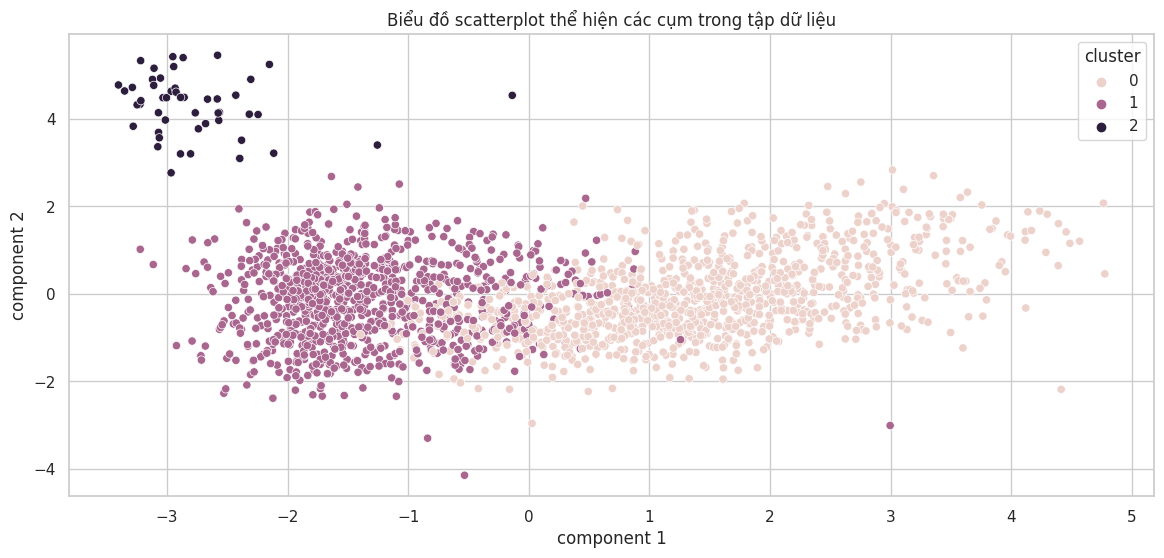

In [61]:
# Giảm chiều dữ liệu
pca = PCA(n_components = 2)
pca_df = pd.DataFrame(pca.fit_transform(X[X.columns.drop(['cluster'])]), columns = ['component 1', 'component 2'])
pca_df['cluster'] = X['cluster']

# Vẽ biểu đồ trực quan hóa
plt.figure(figsize = (14, 6))
sns.scatterplot(data = pca_df, x = 'component 1', y = 'component 2', hue = 'cluster').set_title('Biểu đồ scatterplot thể hiện các cụm trong tập dữ liệu')
plt.show()

Quan sát biểu đồ trên, ta thấy dữ liệu đa được gom cụm thành 3 nhóm riêng biệt. Trong đó nhóm 2 nằm riêng biệt hẳn so với nhóm 0 và nhóm 1 được chia thành 2 phía của biểu đồ. Tuy nhiên nếu so sánh với biểu đồ tương tự của mô hình K-Means, ta thấy giữa 2 nhóm 0 và 1 có sự lẫn lộn với nhau thay vì tách hẳn ra 2 thành nhóm riêng biệt.

Tiếp theo, ta sẽ vẽ biểu độ cột để thể hiện số lượng khách hàng theo từng các cụm. Trong đó:
- Màu xanh dương: thể hiện cho cụm 0.
- Màu cam: thể hiện cho cụm 1.
- Màu xanh lá: thể hiện cho cụm 2.

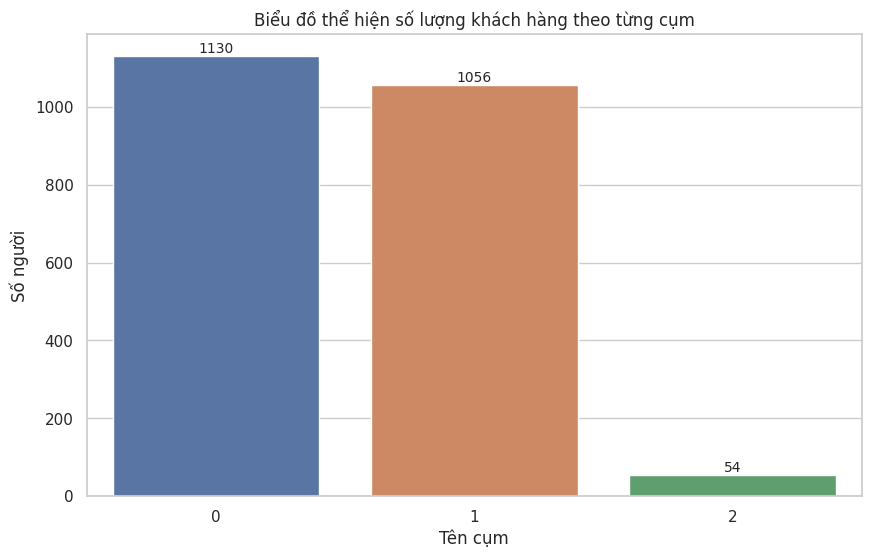

In [62]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(data = X, x = 'cluster', ax = ax)
ax.bar_label(ax.containers[0], fontsize = 10)
plt.title('Biểu đồ thể hiện số lượng khách hàng theo từng cụm')
plt.xlabel('Tên cụm')
plt.ylabel('Số người')
plt.show()

Quan sát biểu đồ trên, ta thấy số lượng khách thuộc **cụm 0** chiếm nhiều nhất, sau đó tới **cụm 1** và cuối cùng số lượng khách thuộc **cụm 2** chiếm ít nhất. Có sự khác biệt giữa số lượng cụm chiếm nhiều nhất giữa mô hình K-Means và mô hình BIRCH.

Tương tự như trên, cuối cùng ta sẽ vẽ các biểu đồ histogram thể hiện phân phối của từng thuộc tính theo từng cụm. Trong đó:
- Màu cam: thể hiện cho cụm -1.
- Màu đỏ: thể hiện cho cụm 0.
- Màu xanh lá: thể hiện cho cụm 1.
- Màu xanh dương: thể hiện cho cụm 2.

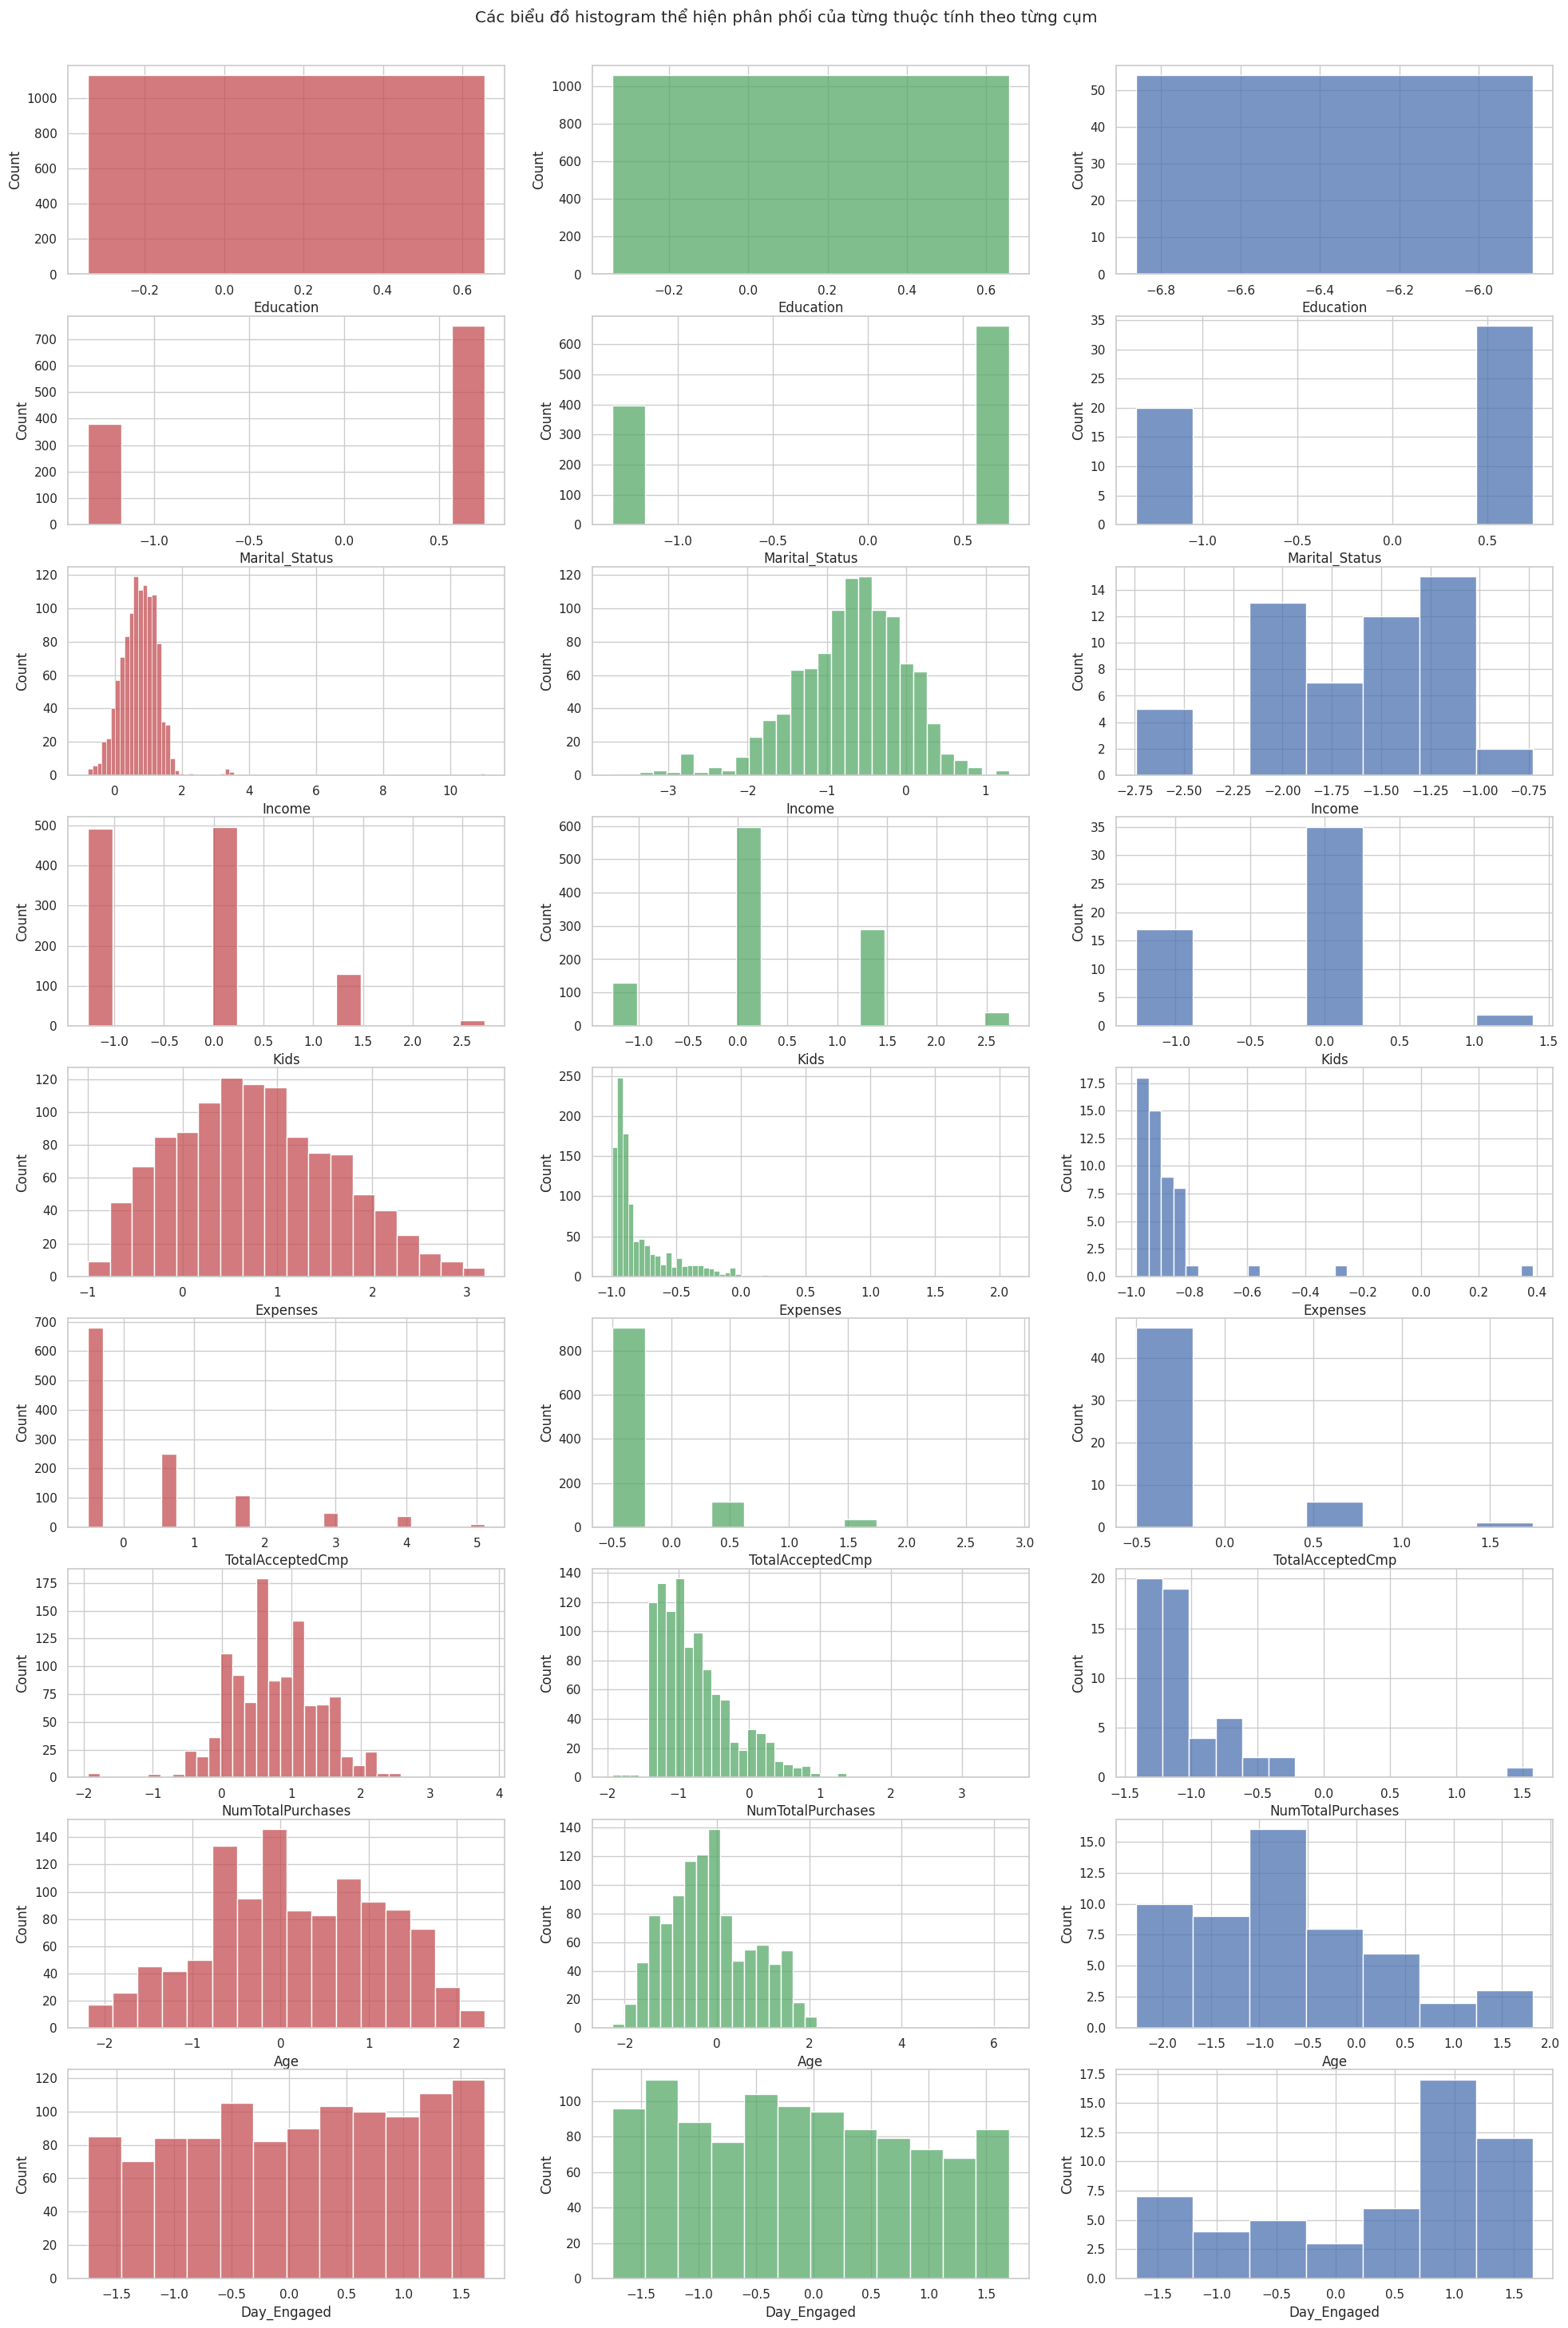

In [63]:
X_0 = X[X['cluster'] == 0]
X_1 = X[X['cluster'] == 1]
X_2 = X[X['cluster'] == 2]

fig, axs = plt.subplots(9, 3, figsize = (24, 36))
idx = 0
for i in min_df.columns:
    sns.histplot(X_0[i], ax = axs[idx, 0], color = 'r')
    sns.histplot(X_1[i], ax = axs[idx, 1], color = 'g')
    sns.histplot(X_2[i], ax = axs[idx, 2], color = 'b')
    idx += 1
plt.suptitle('Các biểu đồ histogram thể hiện phân phối của từng thuộc tính theo từng cụm', y = 0.9)
plt.show()

**Nhận xét:** Quan sát các biểu đồ trên, ta có thể biết được các thông tin sau:
- Dựa trên việc phân cụm có thể chia thành 3 nhóm khách hàng sau: khách hàng tích cực (những khách hàng thuộc cụm 0), khách hàng hoạt động vừa phải (những khách hàng thuộc cụm 1) và khách hàng ít hoạt động nhất (những khách hàng thuộc cụm 2).
- Đặc điểm của nhóm khách hàng tích cực (cụm 0): độ tuổi trải dài **từ 25 đến 75**, có trình độ học vấn đến từ **PG**, khoảng gấp đôi những người này có tình trạng hôn nhân là kết hôn so với độc thân, có thu nhập cao hơn nhóm khách hàng hoạt động vừa phải (đa phần đều không có con), chi tiêu trung bình khoảng **500-2000** cho các lần mua hàng, số ngày hoạt động cũng **tích cực** hơn nên thường họ sẽ gắn bó với công ty lâu dài hơn.
- Đặc điểm của nhóm khách hàng hoạt động vừa phải (cụm 1): độ tuổi **từ 35 đến 50**, cũng có trình độ học vấn đến từ **PG**, khoảng gấp đôi những người này có tình trạng hôn nhân là kết hôn so với độc thân, có thu nhập không bằng nhóm khách hàng hoạt động tích cực, trung bình mỗi gia đình có **1 đứa con**, chi tiêu trung bình khoảng **100-500** cho các lần mua hàng, và khách hàng hoạt động vừa phải **ít tương tác** hơn một chút so với nhóm khách hàng tích cực.
- Đặc điểm của nhóm khách hàng ít hoạt động (cụm 2): độ tuổi **từ 15 đến 30**, có trình độ học vấn đến từ **UG**, khoảng gấp đôi những người này có tình trạng hôn nhân là kết hôn so với độc thân, có thu nhập **rất ít** hoặc không đáng kể (do chưa có công việc ổn định), chỉ một vài trong số những người này có con, chi tiêu cho các lần mua hàng **khá ít** hoặc không đáng kể, và khách hàng ít hoạt động **không tương tác** nhiều đến công ty.

### Nhận xét

Đối với thuật toán K-Means:
- Ưu điểm của thuật toán K-Means:
  - Đơn giản, dễ hiểu và dễ cài đặt.
- Nhược điểm của thuật toán K-Means:
  - Đối với những bộ dữ liệu có hình dạng phức tạp hoặc mất cân bằng thì thuật toán không hội tụ.
  - Thuật toán rất nhạy cảm với outliers.

Đối với thuật toán DBSCAN:
- Ưu điểm của thuật toán DBSCAN:
  - Loại bỏ được các điểm dữ liệu nhiễu.
  - Hoạt động tốt đối với những dữ liệu có hình dạng phân phối đặc thù.
  - Có tốc độ tính toán nhanh.
- Nhược điểm của thuật toán DBSCAN:
  - Không hiệu quả đối với những dữ liệu có phân phối đều khắp nơi.

Đối với thuật toán BIRCH:
- Ưu điểm của thuật toán BIRCH:
  - Có tốc độ thực hiện nhanh do sử dụng cấu trúc cây CF.
- Nhược điểm của thuật toán BIRCH:
  - Chất lượng các cụm được chia không tốt.
  - Không thích hợp với dữ liệu có nhiều chiều.